# Problem Statement


## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Imports & Data Loading

In [117]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFE
import time

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Read the data
cust = pd.read_csv("data/telecom_churn_data.csv")

In [9]:
cust.shape

(99999, 226)

In [10]:
cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [11]:
# Smaller file to manually check on the first 10 records in the dataset
cust.head(10).T.to_csv("sample_10_T.csv")

In [12]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Utility Methods

## Check for missing values in a dataframe

In [13]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        #"Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

# Data Preprocessing

## <TODO> Check data types

In [14]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Date columns are present as objects. Convert to datetime type.

In [15]:
# Change data type of date columns to datetime
date_cols = [col for col in cust.columns if re.match('^date|^last_date', col)]
cust[date_cols] = cust[date_cols].apply(pd.to_datetime,errors='coerce') 

## Check for missing data

In [16]:
print_missing_columns(cust)

,Missing,Missing %,Unique Count
count_rech_2g_6,74846,74.846748,31
max_rech_data_6,74846,74.846748,48
arpu_3g_6,74846,74.846748,7418
av_rech_amt_data_6,74846,74.846748,887
count_rech_3g_6,74846,74.846748,25
night_pck_user_6,74846,74.846748,2
arpu_2g_6,74846,74.846748,6990
fb_user_6,74846,74.846748,2
total_rech_data_6,74846,74.846748,37
date_of_last_rech_data_6,74846,74.846748,30


## Handle missing data

### Replace missing with 0
- Missing 'incoming' & 'outgoing' call related columns can be set to 0 assuming there were no calls received/made for that column type
- Recharge related columns can be set to 0 assuming empty cells indicate no recharge was done in that month
- Minutes of Usage (MoU) and average revenue per user (arpu) columns are also handled similarly 

In [17]:
cust.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [18]:
# Incoming calls column:
# All columns with incoming call information have the string "ic_" in the column name
# Fill the missing values in these columns with 0
incoming_cols = [col for col in cust.columns if 'ic_' in col]
cust[incoming_cols] = cust[incoming_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(incoming_cols)} incoming columns:{incoming_cols}')

# Outgoing calls column:
# All columns with outgoing call information have the string "og_" in the column name
# Fill the missing values in these columns with 0
outcoming_cols = [col for col in cust.columns if 'og_' in col]
cust[outcoming_cols] = cust[outcoming_cols].fillna(0)
print(f'\nReplaced missing values with 0 for {len(outcoming_cols)} outgoing columns:{outcoming_cols}')

Replaced missing values with 0 for 57 incoming columns:['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'i

In [19]:
# Recharge related columns
rech_cols = [col for col in cust.columns if re.match('^count_rech_|^max_rech_|^total_rech_|^av_rech_', col)]
cust[rech_cols] = cust[rech_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(rech_cols)} recharge columns :{rech_cols}')

Replaced missing values with 0 for 32 recharge columns :['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [20]:
# arpu related columns
arpu_cols = [col for col in cust.columns if re.match('^arpu', col)]
cust[arpu_cols] = cust[arpu_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(arpu_cols)} arpu columns :{arpu_cols}')

Replaced missing values with 0 for 12 arpu columns :['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']


### Handle date columns

- Last recharges made for talktime and data for each month is provided in the input data<br>
- With this information, we will create a new derived column which has the number of days since the last recharge <br>
- Combine the columns for the good phase & action phase (months 6, 7 & 8) and get the latest date when a recharge was made <br>
- At the beginning of 9th month, get the number of days since the last recharge <br>
<br>
Hypothesis - if the customer has done a recharge recently, they are less likely to churn.  <br>

In [21]:
print(f'Shape before handling date columns:{cust.shape}')

Shape before handling date columns:(99999, 226)


In [22]:
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [23]:
cust[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].tail()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
99994,2014-06-03,2014-07-20,2014-08-26
99995,2014-06-17,2014-07-17,2014-08-24
99996,2014-06-13,2014-07-26,NaT
99997,2014-06-17,2014-07-19,2014-08-20
99998,2014-06-16,NaT,NaT


In [24]:
# Find the last recharge date in the good phase & action phase (gaphase) together (Months 6,7,8)
last_rech_date_cols = [col for col in cust.columns if re.match('^date_of_last_.*[_6|_7|_8]$', col)]
cust['last_rech_date_gaphase'] = cust[last_rech_date_cols].apply(lambda x: x.max(),axis=1)

In [25]:
# Check for missing values
cust['last_rech_date_gaphase'].isnull().sum()

99

In [26]:
# Missing values in this new column implies no recharge has happend in the 3 months.
# Fill missing value with last date of previous month before the start of good phase
last_rech_date_missing = datetime.datetime(2014, 5, 31)
cust['last_rech_date_gaphase']=cust['last_rech_date_gaphase'].fillna(last_rech_date_missing)

In [27]:
# Create column for number of  days since last recharge
last_date_action_phase = datetime.datetime(2014, 8, 31)
cust['last_rech_num_days'] = (last_date_action_phase - cust['last_rech_date_gaphase']).dt.days

In [28]:
cust[['last_rech_date_gaphase','last_rech_num_days']].head()

,last_rech_date_gaphase,last_rech_num_days
0,2014-08-08,23
1,2014-08-28,3
2,2014-08-14,17
3,2014-08-31,0
4,2014-08-09,22


In [29]:
# drop date columns after creating the days columns
print(f'Shape before dropping date columns:{cust.shape}')
cust.drop(date_cols,inplace=True,axis=1)
cust.drop('last_rech_date_gaphase',inplace=True,axis=1)
print(f'Shape after dropping date columns:{cust.shape}')

Shape before dropping date columns:(99999, 228)
Shape after dropping date columns:(99999, 215)


In [30]:
print_missing_columns(cust)

,Missing,Missing %,Unique Count
night_pck_user_6,74846,74.846748,2
fb_user_6,74846,74.846748,2
night_pck_user_7,74428,74.428744,2
fb_user_7,74428,74.428744,2
night_pck_user_9,74077,74.077741,2
fb_user_9,74077,74.077741,2
night_pck_user_8,73660,73.660737,2
fb_user_8,73660,73.660737,2
onnet_mou_9,7745,7.745077,23565
offnet_mou_9,7745,7.745077,30077


The remaining missing values are filled using the IterativeImputer in sklearn

### Replace binary category values with mode

In [31]:
# Fill the remaining categorical columns with mode
fb_night_cols = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]
for col in fb_night_cols:
    cust[col].fillna(cust[col].mode()[0],inplace=True)

### IterativeImputer

In [32]:
# Use iterative imputer to fill the rest of the missing colums (fOFFNET/ONNET MOU columns)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer()

# OFFNET/ONNET MOU related columns
mou_cols = [col for col in cust.columns if re.match('^onnet_mou|^offnet_mou', col)]
cust[mou_cols] = iter_imputer.fit_transform(cust[mou_cols])

In [33]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

## Check & Treat for outliers

In [34]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days
count,9.999900e+04,99999.0,99999.0,99999.0,99999.0,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,131.988197,...,0.978470,0.976670,0.971240,0.963960,1219.854749,68.170248,66.839062,60.021204,3.299373,7.148231
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,293.704269,...,0.145144,0.150951,0.167133,0.186392,954.733842,267.580450,271.201856,253.938223,32.408353,10.683080
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,-44.674940,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,7.000025e+09,109.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7.000122e+09,109.0,0.0,0.0,0.0,1.500000,0.750000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000244e+09,109.0,0.0,0.0,0.0,31.647200,29.355800,18.054200,0.090000,0.350000,...,1.000000,1.000000,1.000000,1.000000,286.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,8.030000,...,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,36.640000,...,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,123.340000,...,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000,7.000000


**NOTE on outliers:** 
- Almost all the columns have outliers in the last one percentile.  
- It requires more domain knowledge to understand on how the outliers should be treated.  
- Some options to treat the outliers:  
    1. Remove rows above the upper cap (could be 99% in this case)
    2. Cap the values in the last percentile to 99%
    3. Don't modify the data if it is expected 
- In this case study, we will check on the arpu columns and remove the outliers in these variables  
 

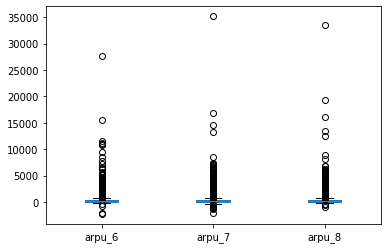

In [35]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [36]:
# Drop outliers with a cap of 99% on the arpu columns
columns_outliers = ['arpu_6','arpu_7','arpu_8']

cap_arpu_6 = cust['arpu_6'].quantile(.99)
cap_arpu_7 = cust['arpu_7'].quantile(.99)
cap_arpu_8 = cust['arpu_8'].quantile(.99)
cust =  cust[(cust['arpu_6'] <= cap_arpu_6) & (cust['arpu_7'] <= cap_arpu_7) & (cust['arpu_8'] <= cap_arpu_8)] 


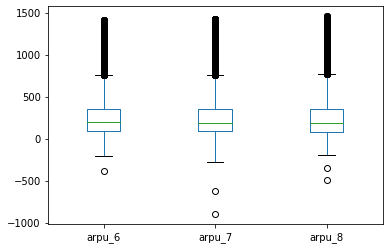

In [37]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [38]:
cust.shape

(98041, 215)

In [39]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days
count,9.804100e+04,98041.0,98041.0,98041.0,98041.0,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,...,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,260.320312,254.611844,255.664261,242.988043,122.938500,...,0.978723,0.976877,0.971665,0.964270,1220.918728,62.048232,60.696221,54.210008,2.923780,7.202079
std,6.958365e+05,0.0,0.0,0.0,0.0,236.731151,236.088674,241.455939,253.622200,256.755997,...,0.144306,0.150295,0.165929,0.185617,955.345362,235.716288,240.844109,223.625920,29.167377,10.711587
min,7.000000e+09,109.0,0.0,0.0,0.0,-383.565000,-897.035000,-491.545000,-1474.195000,-44.674940,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,7.000025e+09,109.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7.000122e+09,109.0,0.0,0.0,0.0,1.350000,0.690000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000244e+09,109.0,0.0,0.0,0.0,31.000000,28.510000,17.749000,0.070000,0.310000,...,1.000000,1.000000,1.000000,1.000000,286.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,91.855000,85.519000,82.788000,61.719000,7.830000,...,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.001204e+09,109.0,0.0,0.0,0.0,193.467000,187.268000,187.879000,173.205000,35.490000,...,1.000000,1.000000,1.000000,1.000000,865.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,357.983000,352.190000,356.587000,342.214000,118.580000,...,1.000000,1.000000,1.000000,1.000000,1811.000000,0.000000,0.000000,0.000000,0.000000,7.000000


## Remove columns with only one unique value. 
Columns with only one unique value will not add much value to the analysis and can be removed

In [40]:
cust = cust[[col for col in cust.columns if cust[col].nunique() > 1]]


## Drop ID column - mobile_number

In [41]:
cust.drop(['mobile_number'],axis=1,inplace=True)

In [42]:
cust.shape

(98041, 202)

In [43]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98041 entries, 0 to 99998
Columns: 202 entries, arpu_6 to last_rech_num_days
dtypes: float64(168), int64(34)
memory usage: 151.8 MB


In [44]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

# Target Variable Creation

## Create Target variable from 9th Month

Create the target variable based on the below rule:
 
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9,
total_og_mou_9,
vol_2g_mb_9,
vol_3g_mb_9

In [45]:
# Create churn flag based on the 9th month variables. 
cust['churn'] = (cust['total_ic_mou_9']+cust['total_og_mou_9']+cust['vol_2g_mb_9']+cust['vol_3g_mb_9']) == 0
cust['churn']=cust['churn'].map({True:1,False:0})

In [46]:
cust['churn'].value_counts()

0    88102
1     9939
Name: churn, dtype: int64

## Remove 9th month variables

In [47]:
# drop the columns with the suffix _9, they should not be used while training the model.

print(f'Shape before dropping 9th month columns:{cust.shape}')
month_9_cols = [col for col in cust.columns if re.search('_9$', col)]
cust.drop(month_9_cols,inplace=True,axis=1)
print(f'Shape after dropping 9th month columns:{cust.shape}')

Shape before dropping 9th month columns:(98041, 203)
Shape after dropping 9th month columns:(98041, 154)


Remove the 9th month variables after creating the target variables. Would otherwise lead to data leakage.

# Identify High Value Customers

We need to predict churn only for the high-value customers. <br>
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

## Find average of M6,M7

In [48]:
cust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days,churn
0,197.385,214.816,213.803,53.070302,27.480769,0.00,81.437483,44.940882,0.00,0.0,...,1.0,1.0,1.0,968,30.4,0.0,101.20,3.58,23,1
1,34.047,355.074,268.321,24.110000,78.680000,7.68,15.740000,99.840000,304.76,0.0,...,1.0,1.0,1.0,1006,0.0,0.0,0.00,0.00,3,0
2,167.690,189.058,210.226,11.540000,55.240000,37.26,143.330000,220.590000,208.36,0.0,...,1.0,1.0,1.0,1103,0.0,0.0,4.17,0.00,17,0
3,221.338,251.102,508.054,99.910000,54.390000,310.98,123.310000,109.010000,71.68,0.0,...,1.0,1.0,1.0,2491,0.0,0.0,0.00,0.00,0,0
4,261.636,309.876,238.174,50.310000,149.440000,83.89,76.960000,91.880000,124.26,0.0,...,0.0,1.0,1.0,1526,0.0,0.0,0.00,0.00,22,0


In [49]:
m6_cols = [col for col in cust.columns if re.search('.*rech.*_6$' , col)]
cust[m6_cols].head()


,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6
0,4,362,252,1.0,252.0,0.0,1.0,252.0
1,4,74,44,0.0,0.0,0.0,0.0,0.0
2,5,168,86,0.0,0.0,0.0,0.0,0.0
3,10,230,60,0.0,0.0,0.0,0.0,0.0
4,5,196,56,1.0,56.0,1.0,0.0,56.0


In [50]:
# Check if total recharge data column is same as sum of no. of recharges in 2G & 3G
print(cust[cust['total_rech_data_6'] != (cust['count_rech_2g_6']+cust['count_rech_3g_6'])].empty)
print(cust[cust['total_rech_data_7'] != (cust['count_rech_2g_7']+cust['count_rech_3g_7'])].empty)

True
True


<b>Assumption:</b> total_rech_amt_* column is only for the talktime recharge and not for data recharge <br>
This information is not clear in the data dictionary and requires domain knowledge. <br>
We can compute the total rech amount for a month as sum of (talktime recharge + data recharge)

In [51]:
cust['avg_rech_amt_6_7'] = ((cust['total_rech_amt_6'] + cust['total_rech_data_6']*cust['av_rech_amt_data_6']) +
                            (cust['total_rech_amt_7'] + cust['total_rech_data_7']*cust['av_rech_amt_data_7']))/2

In [52]:
cust[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_amt_7','avg_rech_amt_6_7']].tail()

,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6,total_rech_data_7,av_rech_amt_data_7,total_rech_amt_7,avg_rech_amt_6_7
99994,60,0.0,0.0,0.0,0.0,110,85.0
99995,110,0.0,0.0,0.0,0.0,110,110.0
99996,119,2.0,39.0,0.0,0.0,0,98.5
99997,381,3.0,583.0,2.0,358.0,358,1602.0
99998,710,1.0,154.0,0.0,0.0,0,432.0


Manually computing the average recharge amount looks to be correct. <br>
We can now identify the value at the 70th percentile to identify the High Value Customers

## Identify value at 70th percentile

In [53]:
cust[['avg_rech_amt_6_7']].describe(percentiles=[0.1,0.3,0.5,0.7,0.9])

,avg_rech_amt_6_7
count,98041.000000
mean,441.626129
std,675.546034
min,0.000000
10%,60.000000
30%,151.500000
50%,270.000000
70%,458.500000
90%,944.000000
max,29185.500000


In [54]:
avg_70 = cust[['avg_rech_amt_6_7']].quantile(0.7)[0]
print(f'Value at 70th percentile:{avg_70}')

Value at 70th percentile:458.5


## Flag high value customers

In [55]:
cust['is_hvc'] = cust['avg_rech_amt_6_7'].apply(lambda x: int(x>= avg_70))

In [56]:
cust['is_hvc'].value_counts()

0    68627
1    29414
Name: is_hvc, dtype: int64

## Filter data for high value customers

In [57]:
# create a backup before filtering for high value customers
cust_orig = cust.copy()

In [58]:
# Consider only high value customers for the model creation
cust = cust[cust['is_hvc'] == 1]

In [59]:
cust.shape

(29414, 156)

In [60]:
# drop the newly created variables to identify the HVCs
# Average recharge amount shall be derived later for the good phase and action phase
cust.drop(['is_hvc','avg_rech_amt_6_7'],axis=1,inplace=True)

# Define Variables

In [61]:
DEPENDENT_VARIABLE = 'churn'

# Select numeric columns for EDA
m8_toc_cols = ['loc_og_t2c_mou_8'] # Outgoing calls to call center
aon_cols = ['aon'] # Age on number
mou_cols = [col for col in cust.columns if re.search('^total_.*mou.*' , col)] # Total minutes of usage
arpu_cols = [col for col in cust.columns if re.search('^arpu_.*' , col)] # Average revenue per user

CONTINUOUS_VAR_TO_ANALYSE = m8_toc_cols+aon_cols+mou_cols+arpu_cols

# Select categorical columns for EDA
BINARY_CATEGORICAL_VARIABLES = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]

In [62]:
cust[CONTINUOUS_VAR_TO_ANALYSE].head()

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
0,0.00,968,0.00,0.00,0.00,0.00,0.00,5.44,197.385,214.816,213.803,212.17,212.17,212.17,212.17,212.17,212.17
8,7.15,315,508.36,431.66,171.56,103.86,28.49,16.54,378.721,492.223,137.362,0.00,0.00,19.83,0.00,0.00,0.00
16,0.00,511,346.81,286.01,233.38,364.86,381.56,294.46,430.975,299.869,187.894,0.00,0.00,0.00,0.00,0.00,0.00
21,0.00,720,860.34,1028.79,1068.54,207.09,131.89,261.04,514.453,597.753,637.760,0.00,0.00,0.00,0.00,0.00,0.00
23,17.71,604,134.38,140.04,239.48,119.58,222.89,298.33,74.350,193.897,366.966,0.00,306.57,197.27,0.00,301.78,150.67


# EDA

## Target variable analysis

In [63]:
cust['churn'].isnull().sum()

0

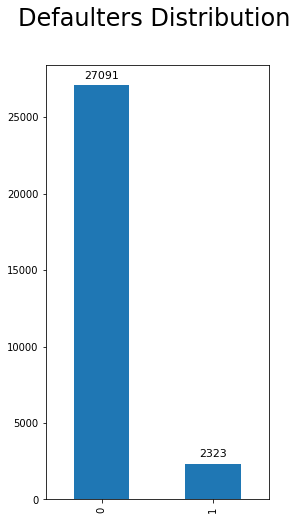

In [64]:
fig = plt.figure(figsize=(4,8))
fig.suptitle('Defaulters Distribution', fontsize=24)
ax = cust[DEPENDENT_VARIABLE].value_counts().plot.bar()
for p in ax.patches: 
    ax.annotate("%0.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11,  xytext=(0, 10), textcoords='offset points')


From the high-value customers filtered, ~8% of the customers are likely to churn.

## Univariate analysis

### Categorical Features


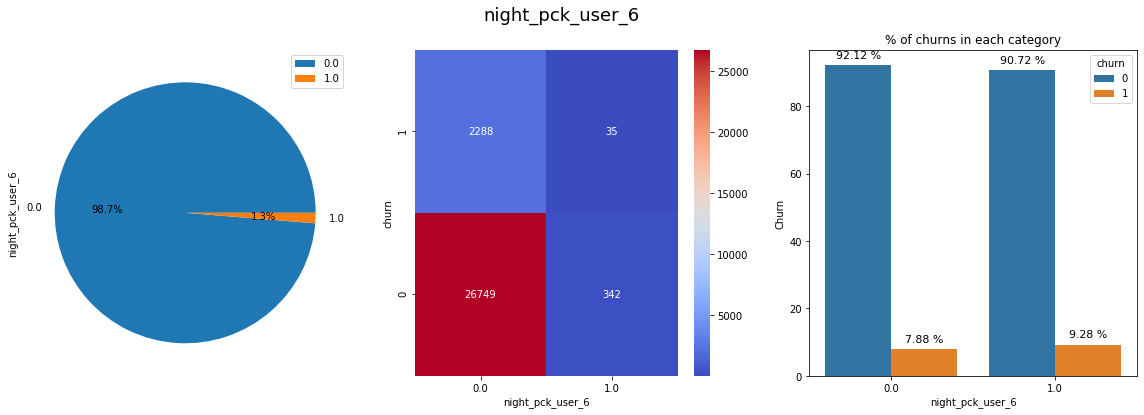

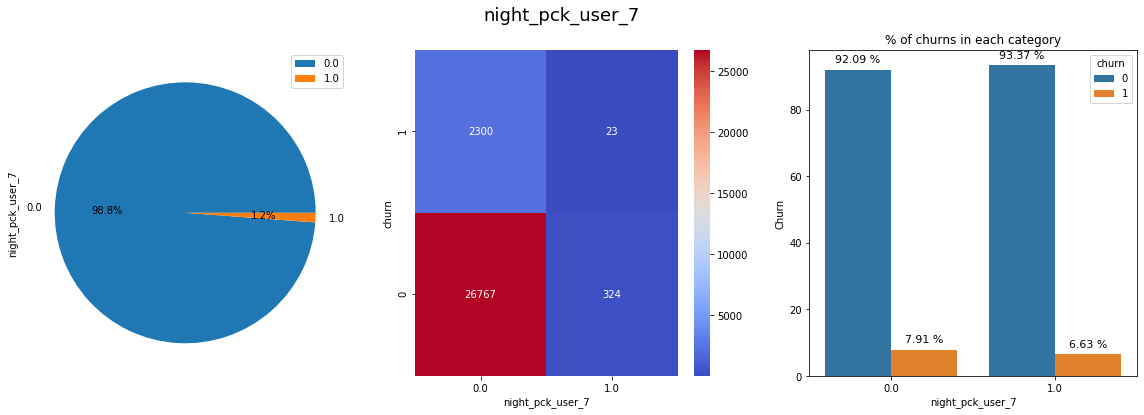

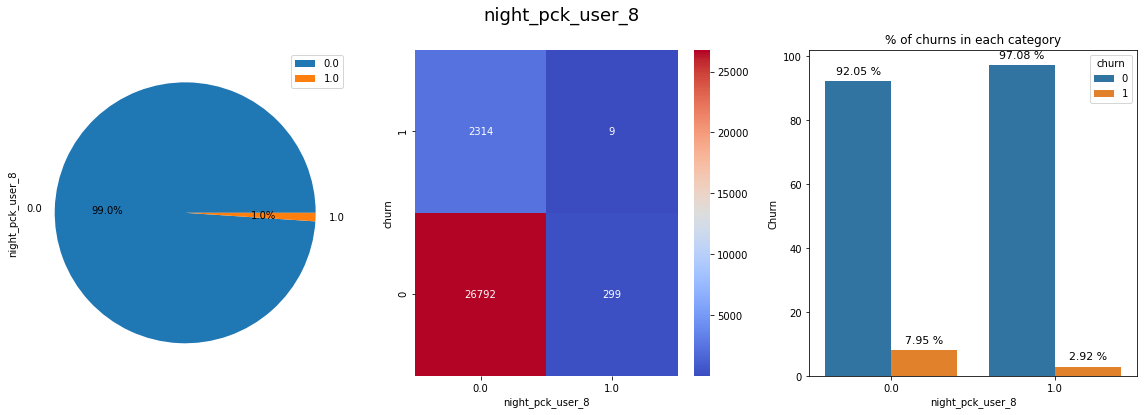

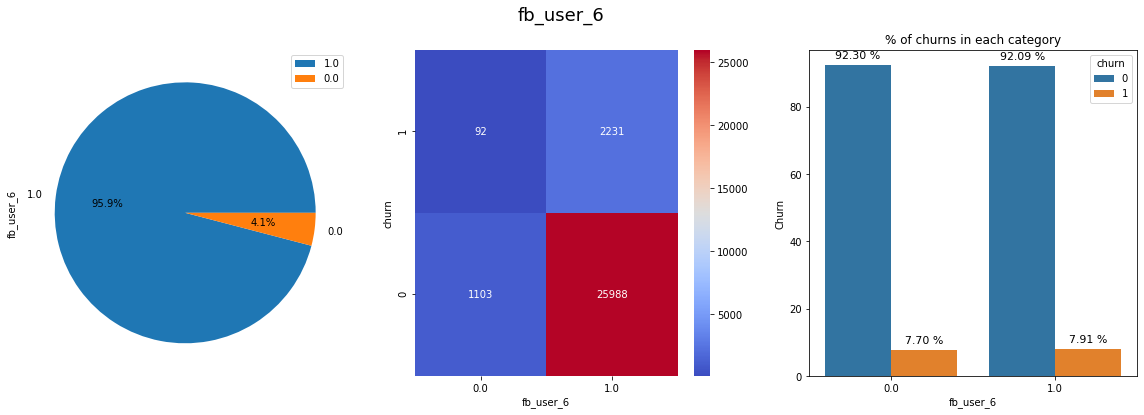

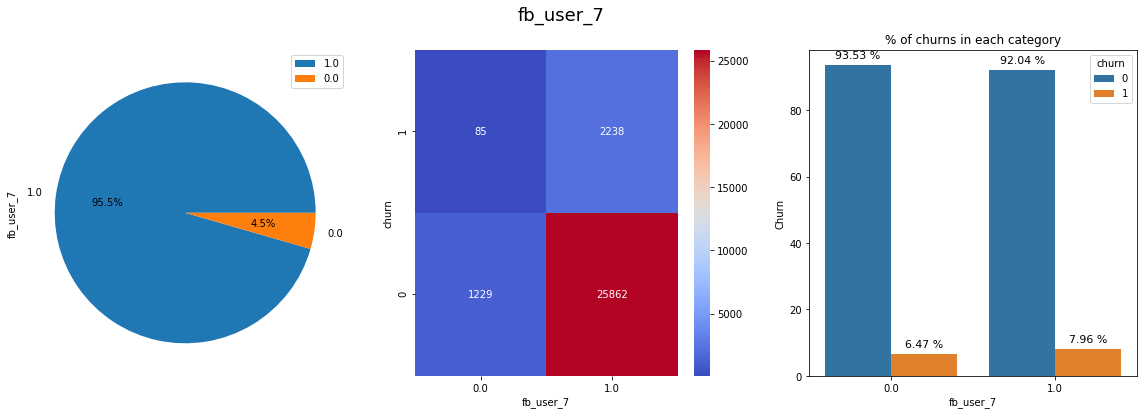

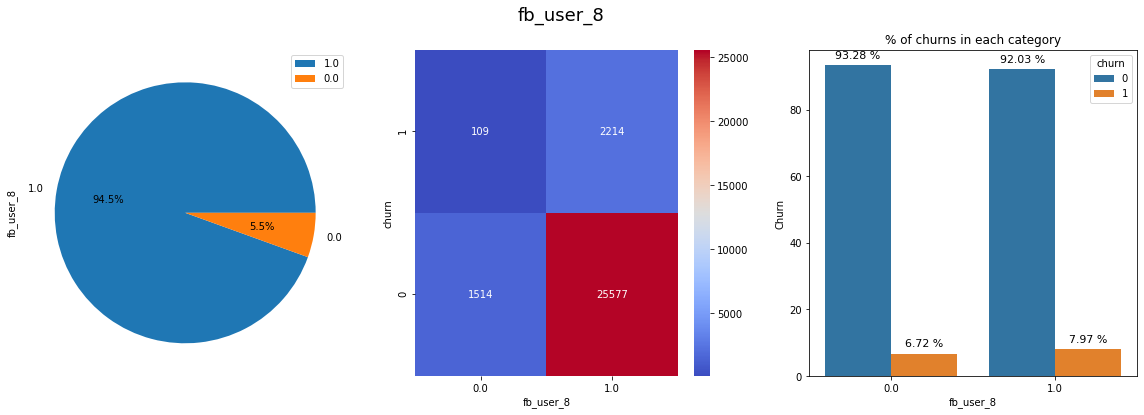

In [65]:

    
# For each categorical variable, plot
# 1. Percentage distribution of each category - Univariate Analysis
# 2. Heatmap of each category against the target variable - Segmented Univariate Analysis
# 3. Grouped bar chart of each category against the target variable - Segmented Univariate Analysis
for col in BINARY_CATEGORICAL_VARIABLES:
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(col, fontsize=18)
    # Chart 1
    cust[col].value_counts().plot.pie(ax=ax[0], autopct="%1.1f%%")
    ax[0].legend()
    # Chart 2
    sns.heatmap(pd.crosstab(index=cust[DEPENDENT_VARIABLE], columns=cust[col]), ax=ax[1], cmap='coolwarm', annot=True, fmt='d') #, annot_kws=akws
    ax[1].set_ylim([0,2])
    # Chart 3 - grouped bar chart
    group_df = pd.DataFrame((cust.groupby([DEPENDENT_VARIABLE,col]).size()/cust.groupby([col]).size()*100).to_frame('count'))
    group_df.reset_index(inplace=True) 
    sns.barplot(x=group_df[col], y=group_df['count'], hue=group_df[DEPENDENT_VARIABLE], ax=ax[2])
    ax[2].set(xlabel=col, ylabel='Churn',title = '% of churns in each category') 

    #annotate axis = seaborn axis
    for p in ax[2].patches:
                 ax[2].annotate("%.2f %%" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11,  xytext=(0, 10),
                     textcoords='offset points')
        
    
    plt.yticks(rotation = 0)
    plt.show()

<font color='green'>
<b>Insights:</b>
    - In both the good phase and in the actioin phse there are ~1% night package users and ~4% facebook users
    - For facebook & social media service clients, the distribution of non-churn to churn is almost the same in both the good phase and in the action phase. 
    - The percentage of night package users who churn during the action phase is lesser.  

</font>

### Continuous Features - Univariate & Segmented Univariate Analysis

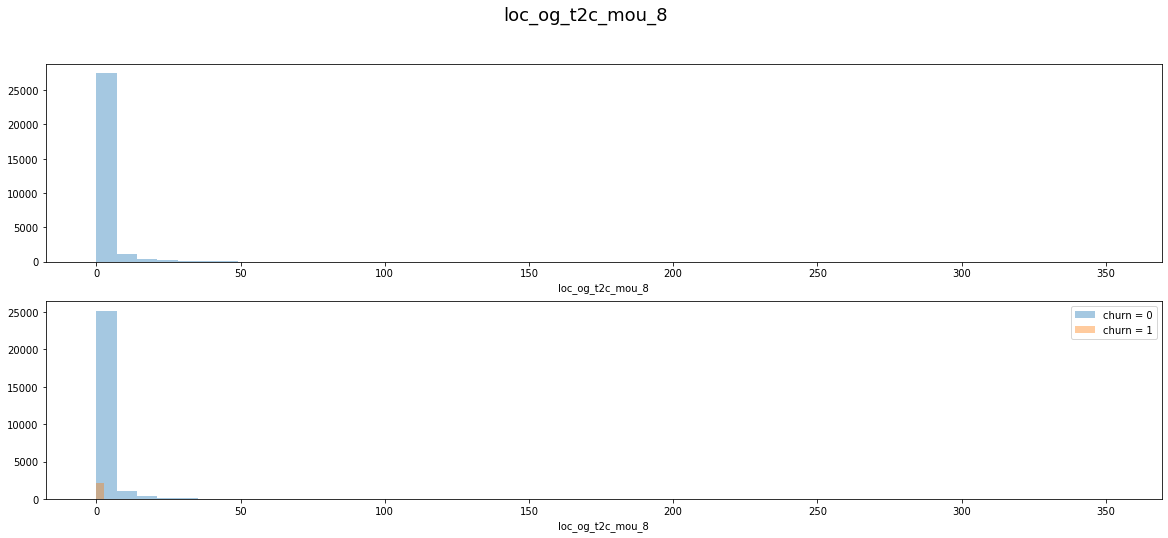

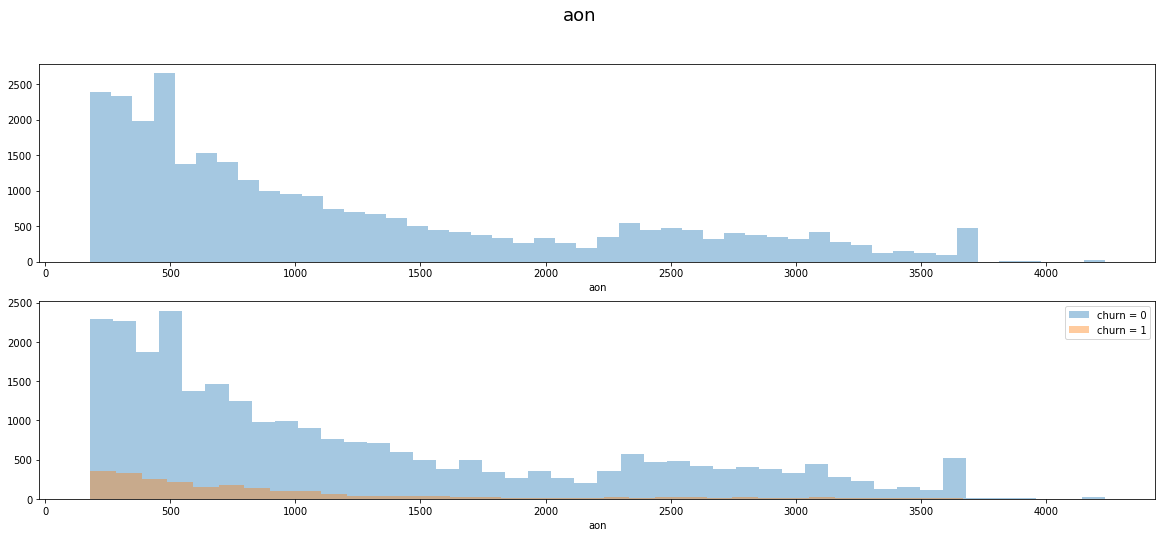

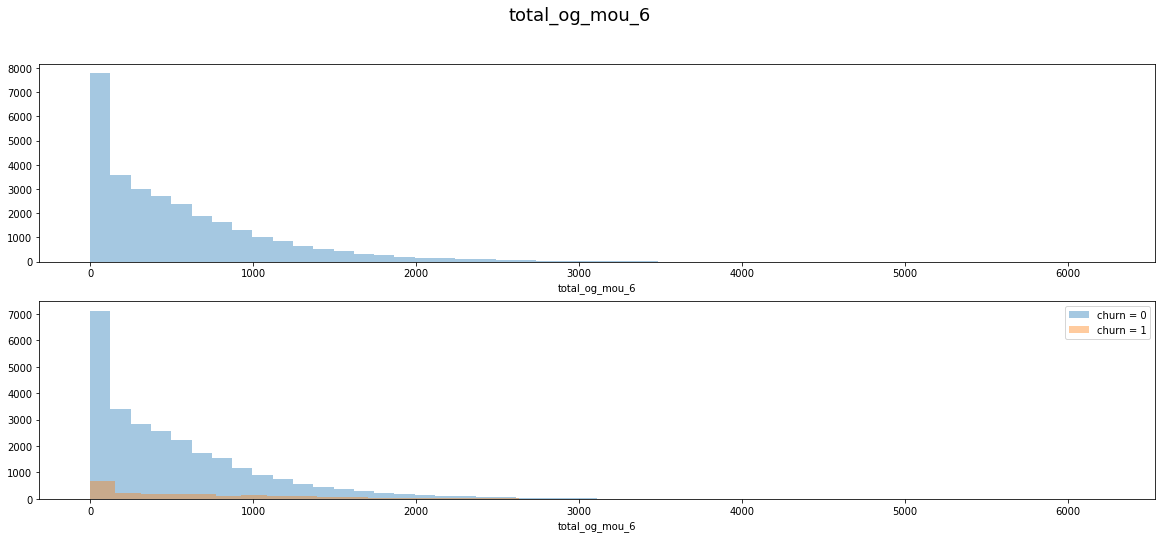

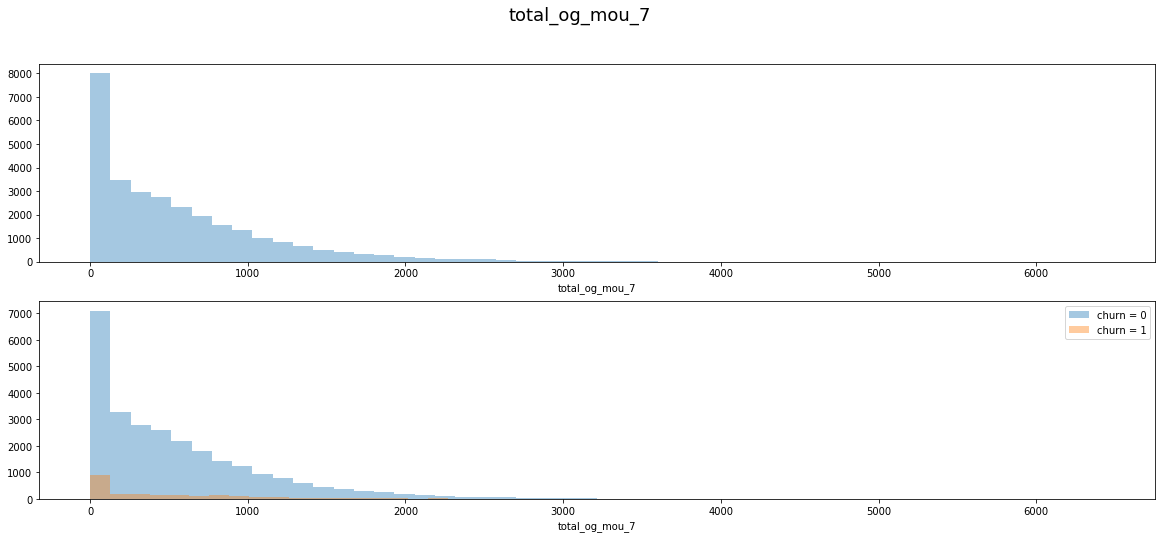

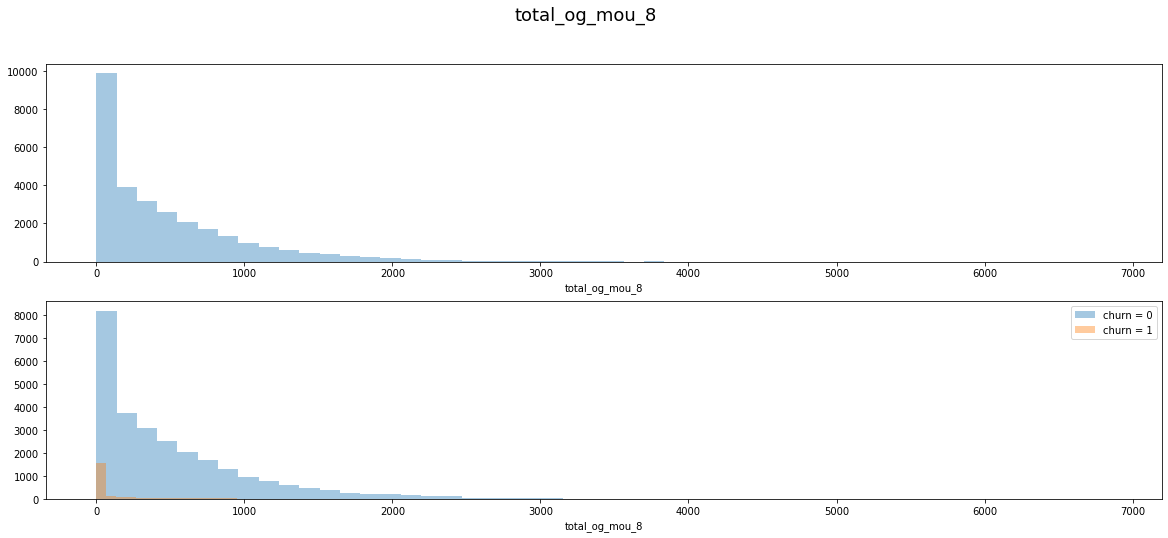

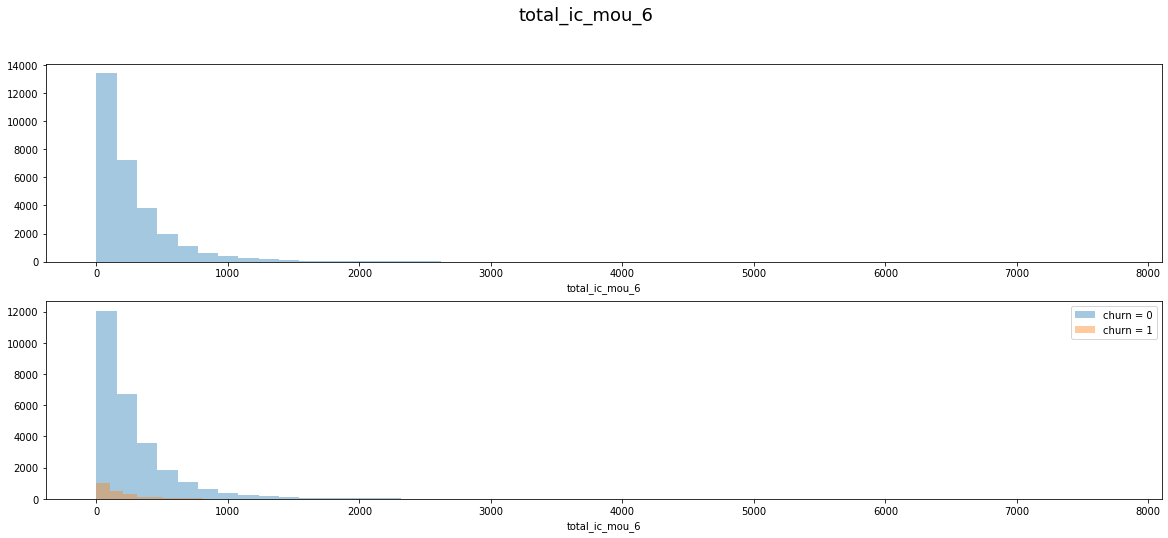

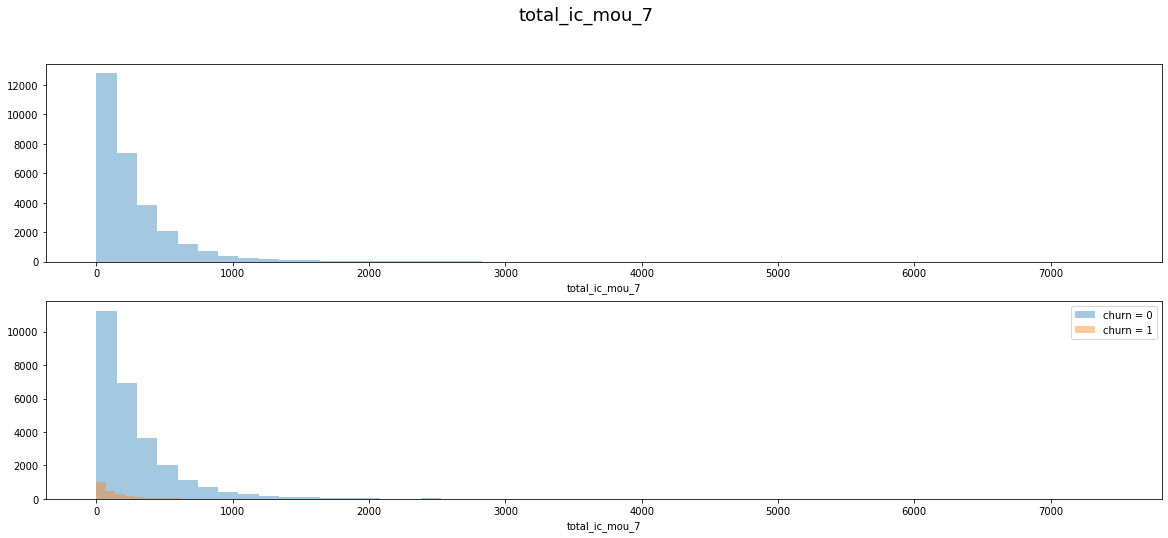

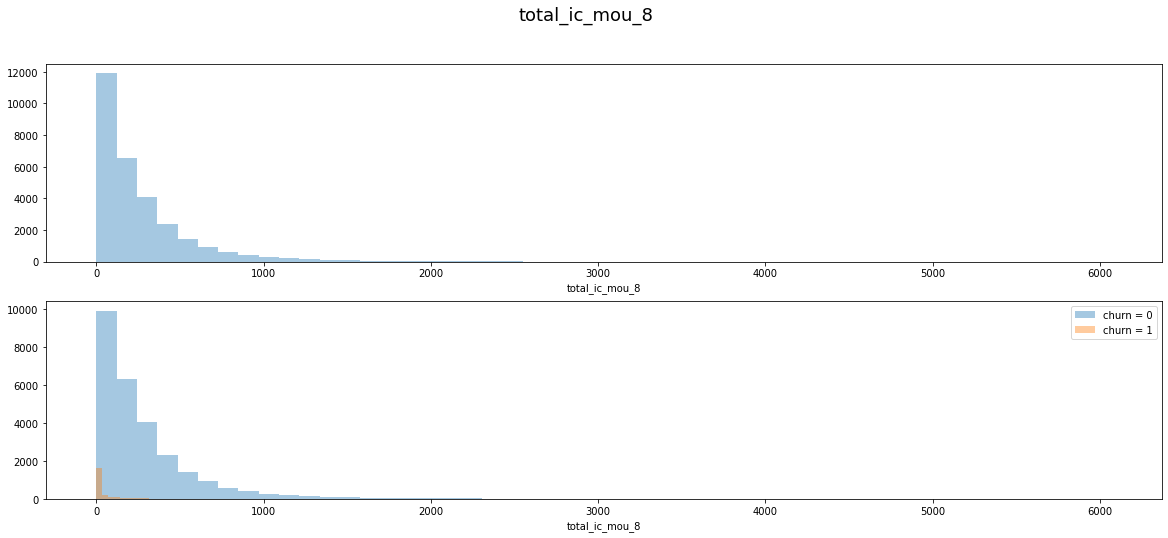

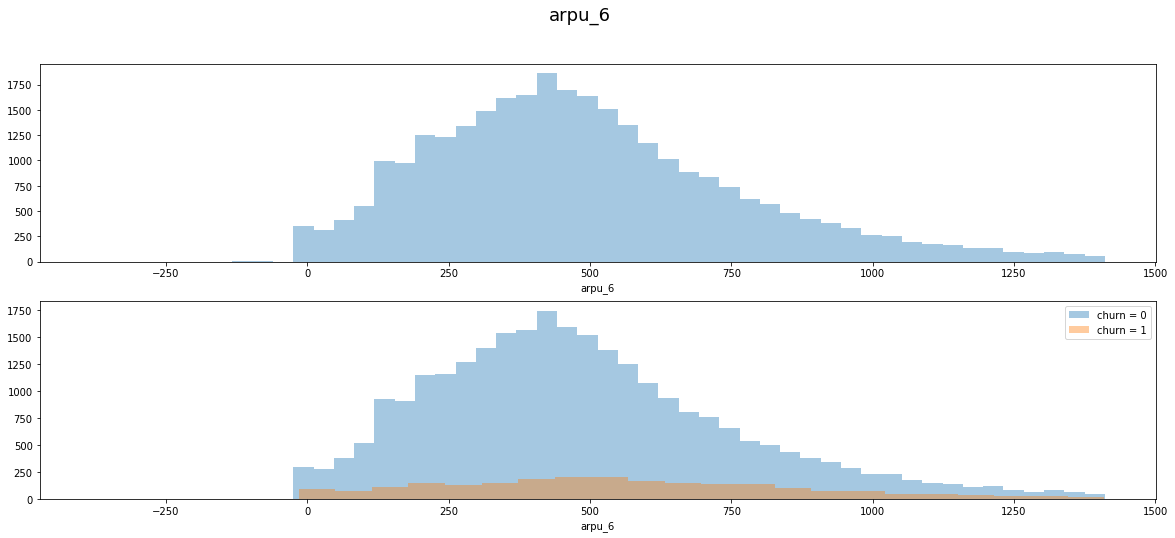

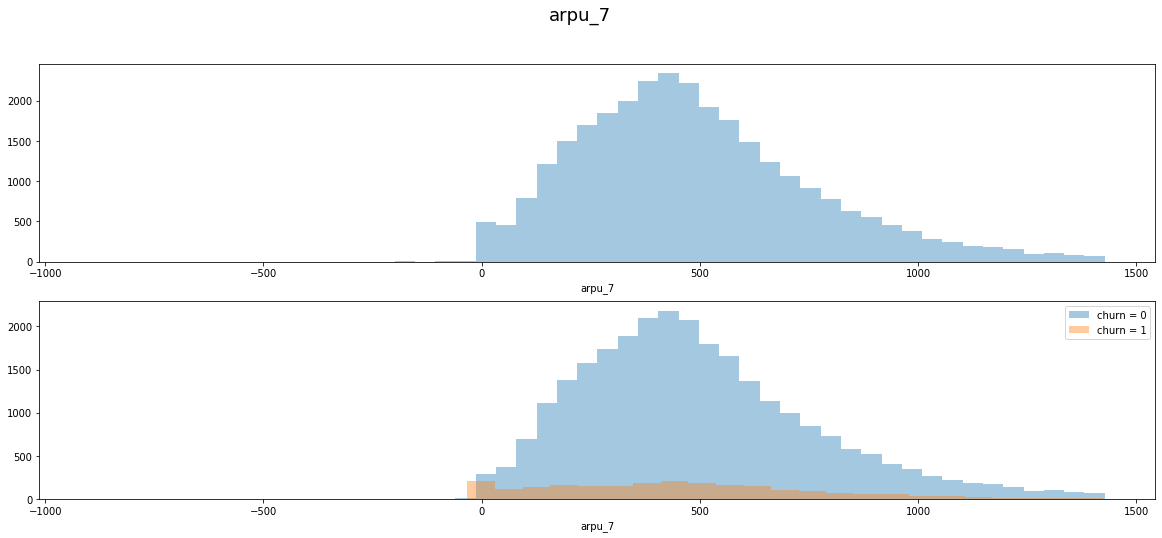

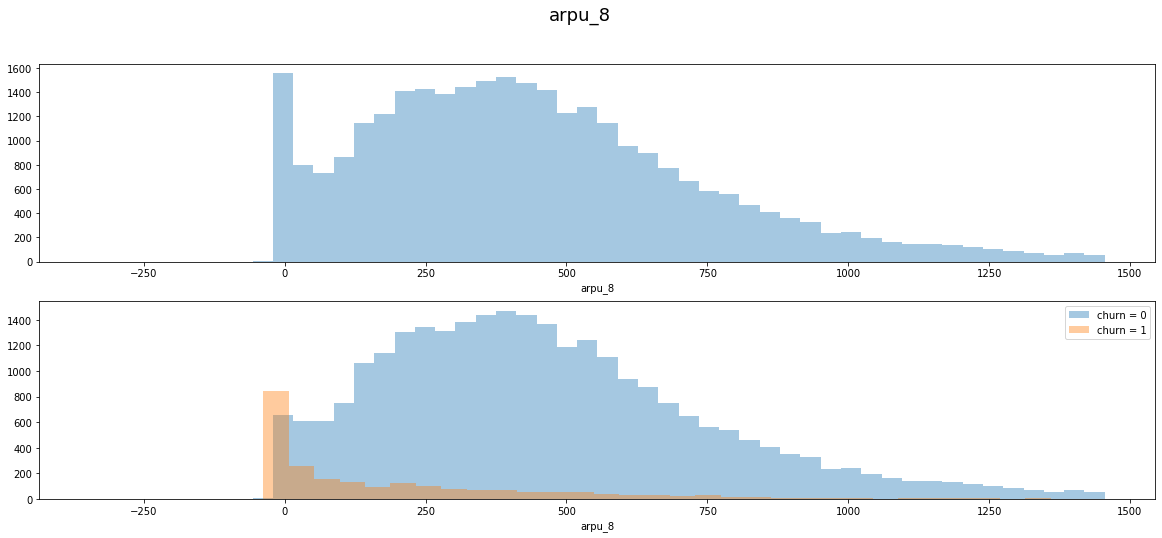

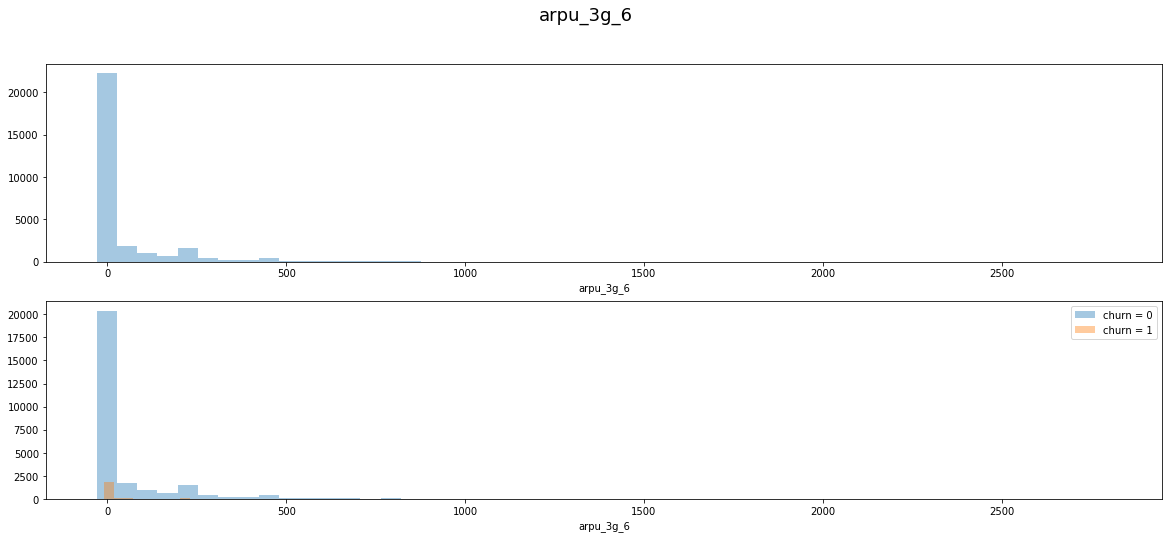

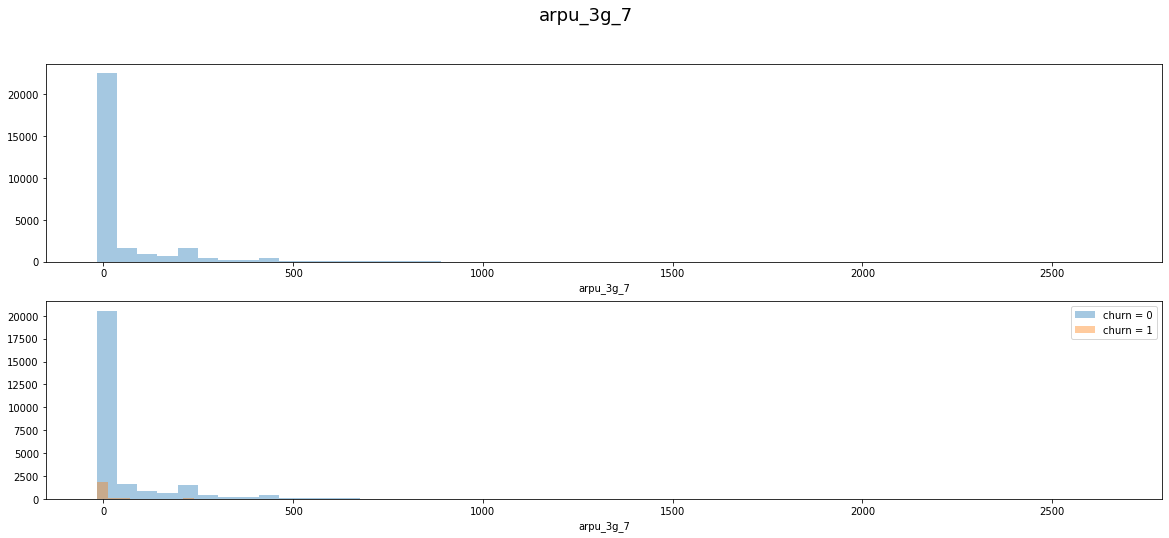

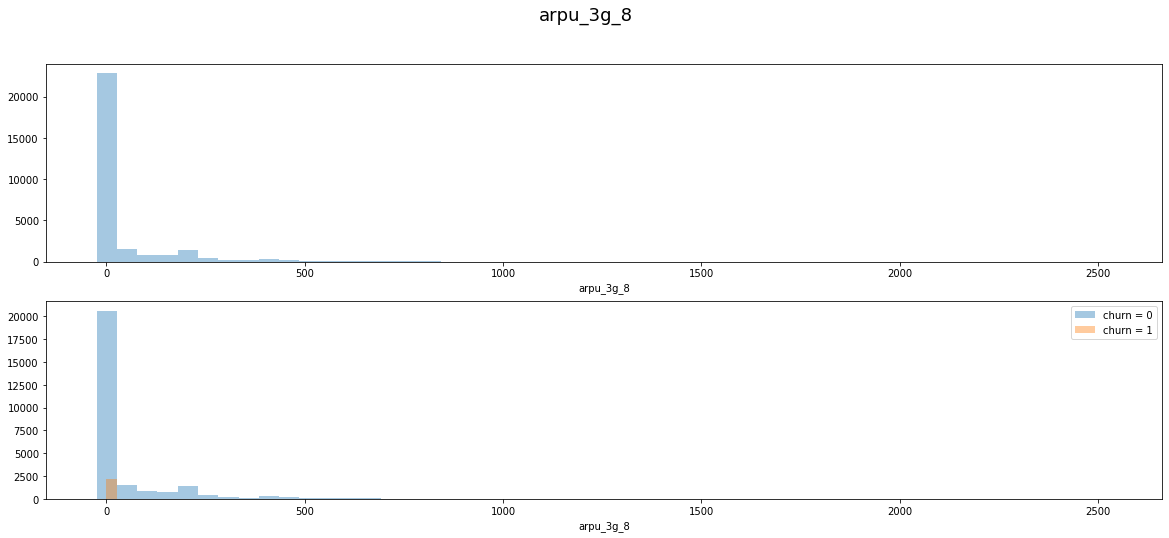

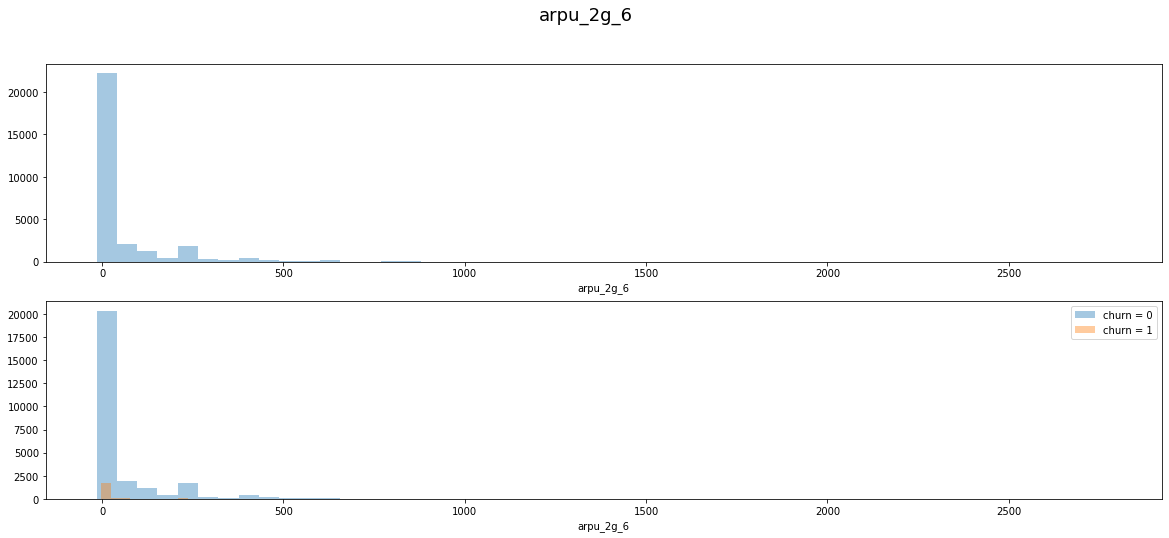

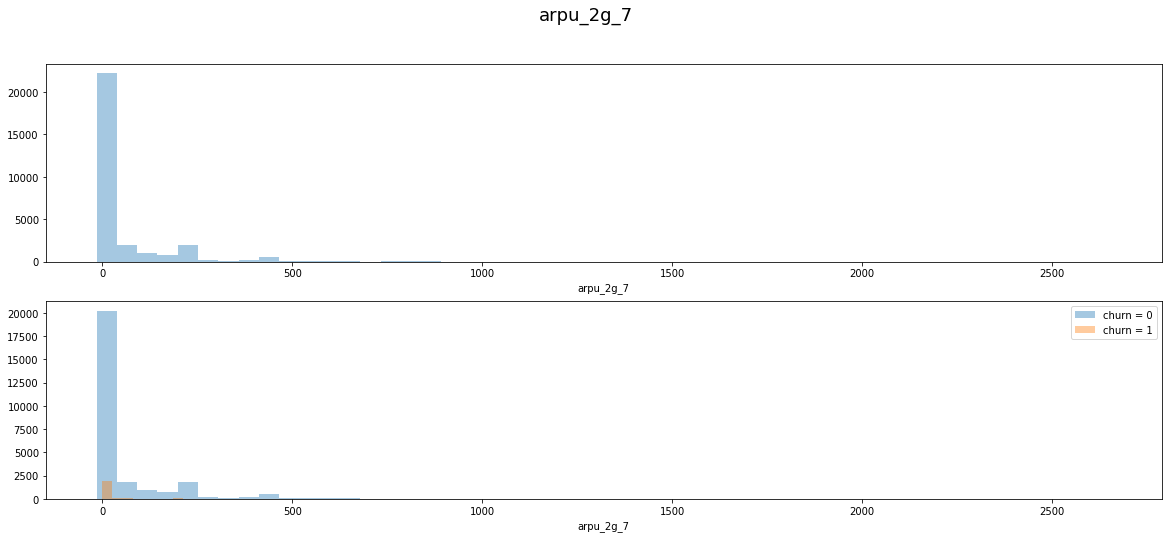

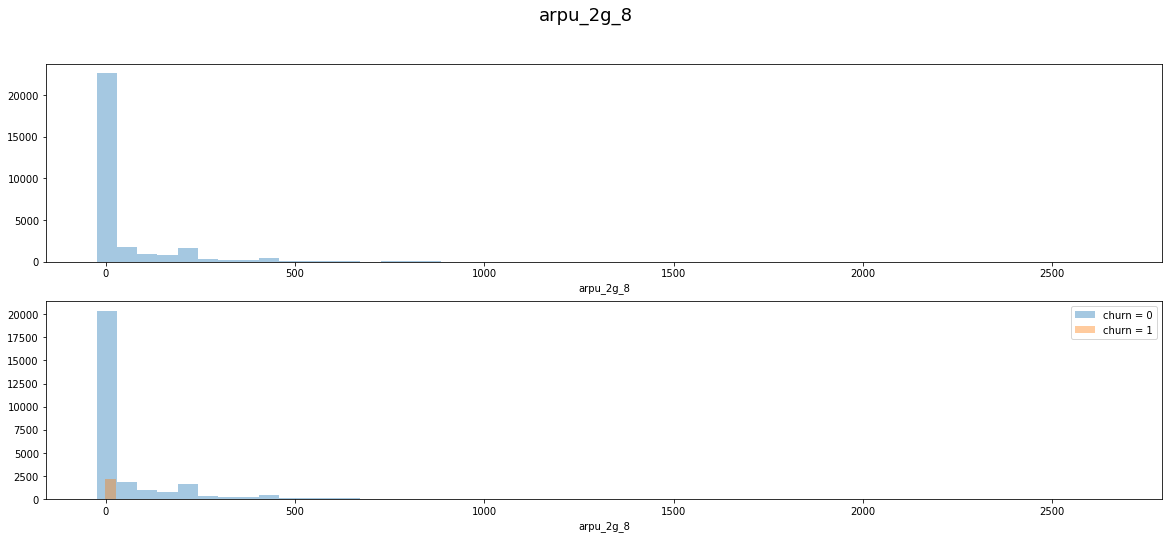

In [66]:

# For each continuous variable, plot
# a. Distribution plot for each continuous variable - Univariate Analysis
# b. Distribution plot against the target variable - Segmented Univariate Analysis
for col in CONTINUOUS_VAR_TO_ANALYSE:
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(cust[col], kde=False, ax=ax[0])
    for i in sorted(cust[DEPENDENT_VARIABLE].unique()):
        sns.distplot(cust[cust[DEPENDENT_VARIABLE] == i][col], kde=False, ax=ax[1], label=f'{DEPENDENT_VARIABLE} = {i}')
    ax[1].legend()

## Bivariate analysis

### Heat map/correlation matrix

In [67]:
df = cust[CONTINUOUS_VAR_TO_ANALYSE + ['churn']]
corr = df.corr() 

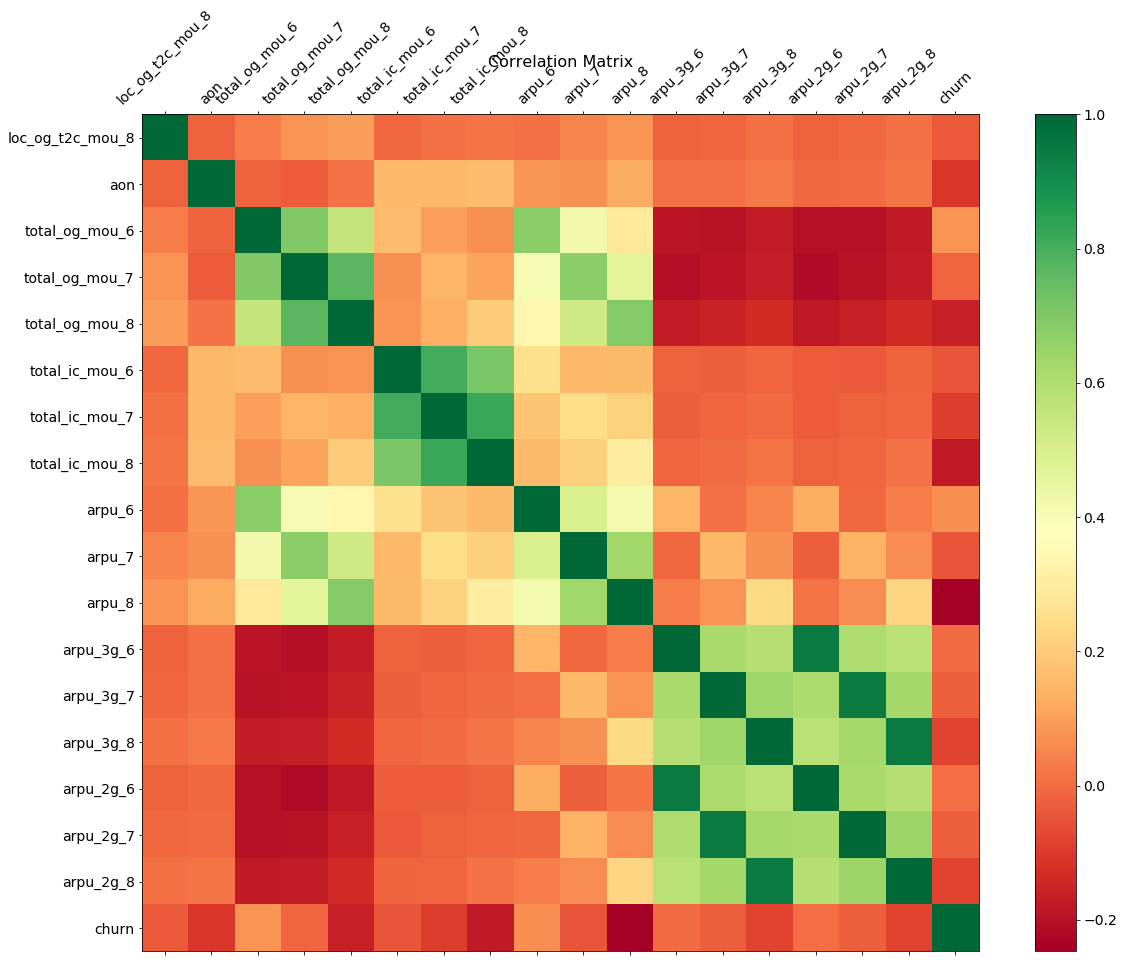

In [68]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [69]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,churn
loc_og_t2c_mou_8,1,-0.02,0.03,0.07,0.1,-0.004,0.008,0.02,0.009,0.05,0.08,-0.02,-0.008,0.009,-0.02,-0.004,0.008,-0.03
aon,-0.02,1,-0.02,-0.03,0.01,0.2,0.2,0.2,0.08,0.07,0.1,0.008,0.01,0.03,-0.004,0.001,0.02,-0.1
total_og_mou_6,0.03,-0.02,1,0.7,0.6,0.2,0.1,0.07,0.7,0.4,0.3,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,0.08
total_og_mou_7,0.07,-0.03,0.7,1,0.8,0.07,0.2,0.1,0.4,0.7,0.5,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.009
total_og_mou_8,0.1,0.01,0.6,0.8,1,0.08,0.1,0.2,0.3,0.5,0.7,-0.2,-0.2,-0.1,-0.2,-0.2,-0.1,-0.2
total_ic_mou_6,-0.004,0.2,0.2,0.07,0.08,1,0.8,0.7,0.3,0.2,0.2,-0.02,-0.02,-0.009,-0.03,-0.03,-0.02,-0.05
total_ic_mou_7,0.008,0.2,0.1,0.2,0.1,0.8,1,0.8,0.2,0.2,0.2,-0.02,-0.01,-0.001,-0.03,-0.02,-0.008,-0.09
total_ic_mou_8,0.02,0.2,0.07,0.1,0.2,0.7,0.8,1,0.2,0.2,0.3,-0.01,-0.002,0.02,-0.02,-0.009,0.01,-0.2
arpu_6,0.009,0.08,0.7,0.4,0.3,0.3,0.2,0.2,1,0.5,0.4,0.1,0.01,0.05,0.1,-0.008,0.03,0.07
arpu_7,0.05,0.07,0.4,0.7,0.5,0.2,0.2,0.2,0.5,1,0.6,-0.006,0.2,0.07,-0.02,0.1,0.06,-0.04


In [70]:
# sns.pairplot(df)

<font color='green'> 
    <b>Insights:</b>
- High correlation between 2 consecutive months (M6 & M7, M7 & M8).<br>
- Good correlation between alternate months (M6 & M8)<br>
- Churn is negatively correlated to aon(age on number). If the customer is using the same number for longer duration, then they are less likely to churn.
</font>

# Derive new features

- Derive new features on average usage in good & action phase 
- Derive new feature on usage during action phase vs good phase

In [71]:
# Method to create the derived features for the given column pattern
# 1. Get the average of good phase and action phase
# 2. Get the increase or decrease in the action phase as compared to the average in good phase
# 2. Drops the features from which the new columns were created to remove multicollinearity
def create_derived_avg_variables(pattern,col_prefix):
   # Create columns for the good phase & action phase
    gphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_6|_7]$', col)]
    aphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_8]$', col)]

    # Get average for good phase - Months 6 & 7
    good_phase_average = round((cust[gphase_cols].sum(axis=1))/2,2)
    cust[f'{col_prefix}_gphase_avg'] = good_phase_average

    # Get average for action phase - Month 8
    action_phase_average = round(cust[aphase_cols].sum(axis=1),2)
    cust[f'{col_prefix}_aphase_avg'] = action_phase_average 
    
    # Get the increase or decrease in the action phase as compared to the average in good phase
    # Difference value = (action phase average - good phase average)
    # Hypothesis: If the values are in negative, it implies that the variable has reduced in the action phase as compared to an average in the good phase - more likely to churn
      
    cust[f'{col_prefix}_gaphase_diff'] = round((action_phase_average - good_phase_average),2) 
    
    # Verify Values
    print('Sample data for cross-verification:')
    display(cust[gphase_cols + aphase_cols +[f'{col_prefix}_gphase_avg',f'{col_prefix}_aphase_avg',f'{col_prefix}_gaphase_diff']].tail())
    
    # If there is only one column for the good phase, then it will be same as the _8 column.
    # Remove one of these columns
    if (len(aphase_cols) == 1):
        cust.drop([f'{col_prefix}_aphase_avg'],axis=1,inplace=True)
    # Drop monthly arpu related columns after creating the derived variables
#    cust.drop(gphase_cols, axis=1, inplace=True)
#    cust.drop(aphase_cols, axis=1, inplace=True)

## Derive based on ARPU (Average Revenue Per User)

In [72]:
create_derived_avg_variables('^arpu_.*','arpu')

Sample data for cross-verification:


,arpu_6,arpu_7,arpu_3g_6,arpu_3g_7,arpu_2g_6,arpu_2g_7,arpu_8,arpu_3g_8,arpu_2g_8,arpu_gphase_avg,arpu_aphase_avg,arpu_gaphase_diff
99981,384.316,255.405,212.18,212.18,212.17,212.17,393.474,212.20,212.17,744.21,817.84,73.63
99984,328.594,202.966,0.00,0.00,0.02,8.43,118.707,0.00,6.23,270.00,124.94,-145.06
99986,644.973,455.228,0.88,0.02,0.00,0.00,564.334,0.05,0.00,550.55,564.38,13.83
99988,312.558,512.932,0.00,0.00,0.00,0.00,402.080,5.44,0.00,412.74,407.52,-5.22
99997,322.991,303.386,235.68,301.34,235.68,301.34,606.817,602.68,602.68,850.21,1812.18,961.97


## Derive based on total MOU (Minutes of Usage)

In [73]:
create_derived_avg_variables('^total_og.*mou_','total_og_mou')
create_derived_avg_variables('^total_ic.*mou_','total_ic_mou')

Sample data for cross-verification:


,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_gphase_avg,total_og_mou_aphase_avg,total_og_mou_gaphase_diff
99981,134.81,57.14,164.69,95.98,164.69,68.71
99984,464.58,221.64,23.98,343.11,23.98,-319.13
99986,1600.79,1183.21,1380.01,1392.00,1380.01,-11.99
99988,375.78,451.48,250.79,413.63,250.79,-162.84
99997,0.00,0.00,0.00,0.00,0.00,0.00


Sample data for cross-verification:


,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_gphase_avg,total_ic_mou_aphase_avg,total_ic_mou_gaphase_diff
99981,478.48,344.78,420.46,411.63,420.46,8.83
99984,89.48,123.71,102.81,106.60,102.81,-3.79
99986,580.73,622.28,660.01,601.50,660.01,58.51
99988,998.96,374.98,1233.83,686.97,1233.83,546.86
99997,0.81,11.09,2.29,5.95,2.29,-3.66


## Derive based on volume of data usage

In [74]:
create_derived_avg_variables('^vol_.*','vol')

Sample data for cross-verification:


,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,vol_2g_mb_8,vol_3g_mb_8,vol_gphase_avg,vol_aphase_avg,vol_gaphase_diff
99981,54.81,101.02,692.72,596.91,112.07,1012.70,722.73,1124.77,402.04
99984,1248.50,725.05,0.00,0.00,202.22,0.00,986.78,202.22,-784.56
99986,34.28,16.41,736.01,1129.34,6.47,926.78,958.02,933.25,-24.77
99988,0.00,0.00,0.00,13.56,0.79,678.74,6.78,679.53,672.75
99997,76.51,241.77,1453.63,1382.08,136.47,2683.30,1577.00,2819.77,1242.77


## Derive based on outgoing calls

In [75]:
# # Handle the outgoing calls to customer care separately
# create_derived_avg_variables('^loc_og_t2c_mou_','loc_t2c_og')
# create_derived_avg_variables('^loc_og_.*','loc_og')

## Derive based on incoming calls

In [76]:
# create_derived_avg_variables('^loc_ic_.*','loc_ic')

In [77]:
cust.shape

(29414, 164)

## Derive for the roaming calls

In [78]:
create_derived_avg_variables('^roam_.*_mou_','roam_mou')

Sample data for cross-verification:


,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,roam_ic_mou_8,roam_og_mou_8,roam_mou_gphase_avg,roam_mou_aphase_avg,roam_mou_gaphase_diff
99981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Derive for recharge amount and drop the other rech columns

In [79]:
cust['total_rech_data_amt_6'] = cust['total_rech_data_6']*cust['av_rech_amt_data_6']
cust['total_rech_data_amt_7'] = cust['total_rech_data_7']*cust['av_rech_amt_data_7']
cust['total_rech_data_amt_8'] = cust['total_rech_data_8']*cust['av_rech_amt_data_8']
cust.drop(['total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_data_8','av_rech_amt_data_8'],axis=1,inplace=True)

In [80]:
create_derived_avg_variables('^total_rech_.*amt_','total_rech_amt')
create_derived_avg_variables('^count_rech_.*g_','count_rech')
create_derived_avg_variables('^total_rech_num_','total_rech_num')
create_derived_avg_variables('^max_rech_amt_','max_rech_amt')
create_derived_avg_variables('^max_rech_data_','max_rech_data')
create_derived_avg_variables('^last_day_rch_amt_','last_day_rch_amt')


Sample data for cross-verification:


,total_rech_amt_6,total_rech_amt_7,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_amt_8,total_rech_data_amt_8,total_rech_amt_gphase_avg,total_rech_amt_aphase_avg,total_rech_amt_gaphase_diff
99981,252,372,252.0,252.0,512,252.0,564.0,764.0,200.0
99984,360,239,154.0,484.0,137,585.0,618.5,722.0,103.5
99986,567,1130,17.0,14.0,25,25.0,864.0,50.0,-814.0
99988,380,554,0.0,154.0,504,154.0,544.0,658.0,114.0
99997,381,358,1749.0,716.0,716,2864.0,1602.0,3580.0,1978.0


Sample data for cross-verification:


,count_rech_2g_6,count_rech_2g_7,count_rech_3g_6,count_rech_3g_7,count_rech_2g_8,count_rech_3g_8,count_rech_gphase_avg,count_rech_aphase_avg,count_rech_gaphase_diff
99981,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
99984,1.0,4.0,0.0,0.0,5.0,0.0,2.5,5.0,2.5
99986,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
99988,0.0,1.0,0.0,0.0,1.0,0.0,0.5,1.0,0.5
99997,1.0,0.0,2.0,2.0,0.0,4.0,2.5,4.0,1.5


Sample data for cross-verification:


,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_gphase_avg,total_rech_num_aphase_avg,total_rech_num_gaphase_diff
99981,2,4,3,3.0,3,0.0
99984,8,10,9,9.0,9,0.0
99986,6,8,3,7.0,3,-4.0
99988,12,12,9,12.0,9,-3.0
99997,3,4,4,3.5,4,0.5


Sample data for cross-verification:


,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_gphase_avg,max_rech_amt_aphase_avg,max_rech_amt_gaphase_diff
99981,252,252,252,252.0,252,0.0
99984,154,46,30,100.0,30,-70.0
99986,550,786,25,668.0,25,-643.0
99988,50,154,154,102.0,154,52.0
99997,202,179,179,190.5,179,-11.5


Sample data for cross-verification:


,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_gphase_avg,max_rech_data_aphase_avg,max_rech_data_gaphase_diff
99981,252.0,252.0,252.0,252.0,252.0,0.0
99984,154.0,46.0,25.0,100.0,25.0,-75.0
99986,17.0,14.0,25.0,15.5,25.0,9.5
99988,0.0,154.0,154.0,77.0,154.0,77.0
99997,202.0,179.0,179.0,190.5,179.0,-11.5


Sample data for cross-verification:


,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_gphase_avg,last_day_rch_amt_aphase_avg,last_day_rch_amt_gaphase_diff
99981,252,0,130,126.0,130,4.0
99984,0,25,25,12.5,25,12.5
99986,550,786,0,668.0,0,-668.0
99988,50,50,50,50.0,50,0.0
99997,202,179,179,190.5,179,-11.5


## Derive for std incoming & outgoing

In [81]:
# create_derived_avg_variables('^std_og_.*','std_og')
# create_derived_avg_variables('^std_ic_.*','std_ic')

In [82]:
[col for col in cust.columns if re.search(f'rech', col)]

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'last_rech_num_days',
 'total_rech_data_amt_6',
 'total_rech_data_amt_7',
 'total_rech_data_amt_8',
 'total_rech_amt_gphase_avg',
 'total_rech_amt_aphase_avg',
 'total_rech_amt_gaphase_diff',
 'count_rech_gphase_avg',
 'count_rech_aphase_avg',
 'count_rech_gaphase_diff',
 'total_rech_num_gphase_avg',
 'total_rech_num_gaphase_diff',
 'max_rech_amt_gphase_avg',
 'max_rech_amt_gaphase_diff',
 'max_rech_data_gphase_avg',
 'max_rech_data_gaphase_diff']

In [83]:
cust.shape

(29414, 178)

In [84]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,count_rech_aphase_avg,count_rech_gaphase_diff,total_rech_num_gphase_avg,total_rech_num_gaphase_diff,max_rech_amt_gphase_avg,max_rech_amt_gaphase_diff,max_rech_data_gphase_avg,max_rech_data_gaphase_diff,last_day_rch_amt_gphase_avg,last_day_rch_amt_gaphase_diff
count,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,...,29414.000000,29414.000000,29414.000000,29414.000000,29414.00000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000
mean,491.125666,489.502515,440.508350,238.349738,241.867929,212.586475,333.327240,335.011207,299.739078,13.785125,...,1.589209,-0.135293,11.315462,-1.759706,157.79661,-10.369637,74.548531,-6.339719,92.739614,-7.908173
std,272.250118,269.959599,295.087466,392.116662,404.890163,376.820358,382.883372,391.033290,365.340232,67.001950,...,2.919432,2.152456,8.025683,6.235070,123.04936,116.887140,95.106450,73.611499,94.707809,120.583052
min,-383.565000,-897.035000,-345.129000,0.000000,0.000000,-38.202195,0.000000,0.000000,-18.169255,0.000000,...,0.000000,-30.500000,0.500000,-101.500000,0.00000,-1675.000000,0.000000,-951.000000,0.000000,-1675.000000
1%,2.583010,1.293900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-7.000000,2.000000,-21.500000,22.50000,-475.935000,0.000000,-252.000000,0.000000,-377.175000
5%,109.362650,110.439500,9.215800,0.000000,0.000000,0.000000,2.906500,2.360000,0.690000,0.000000,...,0.000000,-3.000000,3.500000,-11.000000,33.00000,-154.000000,0.000000,-137.000000,0.000000,-153.000000
10%,167.612400,171.449200,81.025100,1.580000,1.330000,0.700000,16.230000,14.282007,9.153000,0.000000,...,0.000000,-2.000000,4.500000,-7.500000,50.00000,-103.000000,0.000000,-78.500000,15.000000,-115.000000
25%,296.511250,296.411750,220.136500,18.880000,17.130000,14.080000,73.032500,70.190000,54.310000,0.000000,...,0.000000,-0.500000,6.000000,-4.000000,98.00000,-32.000000,0.000000,-6.000000,30.000000,-50.000000
50%,456.448500,454.291500,404.138500,83.470000,80.655000,66.790000,208.960000,204.915000,180.480000,0.000000,...,1.000000,0.000000,9.000000,-1.500000,124.00000,0.000000,25.000000,0.000000,74.000000,0.000000
75%,644.119000,641.097500,608.770500,271.597500,268.835000,226.790000,449.837500,455.130000,408.405000,0.000000,...,2.000000,0.000000,14.000000,1.000000,190.00000,24.000000,145.000000,0.000000,120.000000,25.000000


# Split data to independent & dependent variables

In [85]:
X = cust.drop([DEPENDENT_VARIABLE],axis=1)
y = cust[DEPENDENT_VARIABLE]

# Handle class imbalance

In [86]:
cust['churn'].value_counts()

0    27091
1     2323
Name: churn, dtype: int64

<font color='green'>
    <b>Observations on class imbalance:</b><br>
- In the given dataset, churn vs non-churn is at 10%-90%. <br>
- This is a case of class imbalance where one class outnumbers the other. <br>
- We can apply some of the class imbalance techniques to address this issue and observe how the models behave <br>
- In this case study we shall use the oversampling & SMOTE techniques to address the class imbalance issue
</font>

## Oversampling

In [87]:
# import library
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

# fit predictor and target variablex_ros, 
X_oversampled, y_oversampled = over_sampler.fit_resample(X,y)


print(f'''Shape of X before oversampling: {X.shape}
Shape of X after oversampling: {X_oversampled.shape}''')

print('\nBalance of positive and negative classes (%):')
y_oversampled.value_counts(normalize=True) * 100



Shape of X before oversampling: (29414, 177)
Shape of X after oversampling: (54182, 177)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: churn, dtype: float64

## SMOTE

In [88]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_smote.value_counts(normalize=True) * 100

Shape of X before SMOTE: (29414, 177)
Shape of X after SMOTE: (54182, 177)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: churn, dtype: float64

# Train-test split

## Train-test split on original data (without oversampling or SMOTE)

In [89]:
# 70% of data used as train data and the remaining 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=100)

## Train-test split on oversampled data 


In [90]:
# 70% of data used as train data and the remaining 30% as test data
X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test = train_test_split(X_oversampled,y_oversampled,test_size = 0.3, random_state=100)

## Train-test split on SMOTE data 


In [91]:
# 70% of data used as train data and the remaining 30% as test data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,y_smote,test_size = 0.3, random_state=100)

# Feature Scaling

- After the train-test split, the features needs to be scaled as they are of different ranges.  
- Here we will use the MinMaxScaler to scale the data  
- All the 3 sets of data that has been created should be scaled.  
- Scaler should be fit on the training data. Only the transform method needs to be applied on the test data. (To ensure that the min & max values from the train data is used on the test data)

In [92]:
cols_to_scale = X_train.columns

In [93]:
# Scale the original dataset
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale] )

In [94]:
# Scale the oversampled dataset
scaler_os = MinMaxScaler()
X_oversampled_train[cols_to_scale] = scaler_os.fit_transform(X_oversampled_train[cols_to_scale])
X_oversampled_test[cols_to_scale] = scaler_os.transform(X_oversampled_test[cols_to_scale])

In [95]:
# Scale the SMOTE dataset
scaler_smote = MinMaxScaler()
X_smote_train[cols_to_scale] = scaler_smote.fit_transform(X_smote_train[cols_to_scale])
X_smote_test[cols_to_scale] = scaler_smote.transform(X_smote_test[cols_to_scale])

In [96]:
X_train.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,count_rech_aphase_avg,count_rech_gaphase_diff,total_rech_num_gphase_avg,total_rech_num_gaphase_diff,max_rech_amt_gphase_avg,max_rech_amt_gaphase_diff,max_rech_data_gphase_avg,max_rech_data_gaphase_diff,last_day_rch_amt_gphase_avg,last_day_rch_amt_gaphase_diff
count,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,...,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000
mean,0.487316,0.597496,0.436776,0.038691,0.038030,0.040969,0.093515,0.090494,0.089183,0.005221,...,0.026366,0.467106,0.088874,0.637174,0.047795,0.296101,0.047820,0.588621,0.055248,0.296464
std,0.152022,0.116703,0.163758,0.063226,0.063495,0.062661,0.106521,0.105312,0.102338,0.025228,...,0.048359,0.033032,0.066341,0.039819,0.037444,0.021000,0.061564,0.045134,0.056570,0.021567
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378638,0.514150,0.314780,0.003131,0.002719,0.007978,0.020471,0.018908,0.020391,0.000000,...,0.000000,0.461538,0.045082,0.623003,0.030009,0.292319,0.000000,0.589664,0.017910,0.288940
50%,0.467884,0.581677,0.416263,0.013730,0.012786,0.016857,0.058851,0.054975,0.056091,0.000000,...,0.016667,0.469231,0.069672,0.638978,0.037587,0.297831,0.016077,0.592154,0.043582,0.297831
75%,0.572038,0.661841,0.529637,0.044138,0.042076,0.043238,0.127009,0.123153,0.119302,0.000000,...,0.033333,0.469231,0.110656,0.654952,0.057593,0.302098,0.093248,0.592154,0.071642,0.302276
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# SET CONFIGURATIONS

## Set models to be run and compared

In [97]:
# All supported models that can be run
ALL_SUPPORTED_MODELS = ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','SVM_CLASSIFIER','KNN_CLASSIFIER','ADABOOST_CLASSIFIER','MLP_CLASSIFIER']

# Select models that needs to be run (Set to ALL_SUPPORTED_MODELS if all the models has to be run - RunTime could be high)
MODELS_TO_RUN =     ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','ADABOOST_CLASSIFIER']

## Set the evaluation metric

In [98]:
GRID_SEARCH_SCORING  = 'f1'# Metric used to identify the best model during hyperparameter tuning
EVALUATION_METRIC = 'F1 Score' #'Accuracy','AUROC','Sensitivity','Specificity','Precision'
SORT_ASCENDING = False

## Labels in the dataset

In [99]:
labels = list(set(y_test))

## Grid/Random Search for Random Forest - Hyperparameter Tuning

In [100]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 15],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [50, 100, 250, 500]
}

param_comb = 100

# Instantiate the grid search model - takes around 1hr 22m for PCA RF HPT
grid_search_rf = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = GRID_SEARCH_SCORING)

# Instantiate a random search model - to reduce the run-time
random_search_rf = RandomizedSearchCV(estimator=classifier_rf, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=1, random_state=42)


## Random Search for XGBoost - Hyperparameter Tuning


In [101]:
classifier_xgb = XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

# A parameter grid for XGBoost
params = {
        'n_estimators' : [50, 100, 250, 500], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 5, 10, 15]
        }

param_comb = 100 # to reduce run-time  

random_search_xgb = RandomizedSearchCV(classifier_xgb, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=3, random_state=42)


# Helper Functions - Model Building

## Fit & Predict

In [102]:
def model_fit_predict(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_performance_measures(Y_test = y_test, Y_predict = y_pred, labels = labels)

## Print elapsed time in min & sec

In [103]:
def print_elapsed_time(end_time,start_time):
    total_time = end_time - start_time
    print(f'Elapsed time: {total_time//60} min {round(total_time - total_time//60,3)} sec')
    
    

## Run models based on MODELS_TO_RUN list

In [104]:
def run_all_models(X_train, X_test, y_train, y_test,model_type, model_result):
    
    start_time = time.time()
    
    # Logistic Regression
    if 'LOGISTRIC_REGRESSION' in MODELS_TO_RUN:
        print(f'\nRunning Model: Logistic Regression')
        model_start_time = time.time()
        model_result[f'{model_type}-LR'] = model_fit_predict(LogisticRegression(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Decision Tree Classifier
    if 'DECISION_TREE' in MODELS_TO_RUN:
        print(f'\nRunning Model: Decision Tree Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-DCART'] = model_fit_predict(DecisionTreeClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Random Forest Classifier 
    if 'RANDOM_FOREST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Random Forest Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-RF'] = model_fit_predict(RandomForestClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Naive Bayes Classifier
    if 'GAUSSIAN_NAIVE_BAYES' in MODELS_TO_RUN:
        print(f'\nRunning Model: Naive Bayes Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-NB'] = model_fit_predict(GaussianNB(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Gradient Boost Classifier
    if 'GRADIENT_BOOST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Gradient Boost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-GB'] = model_fit_predict(GradientBoostingClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # XGBoost Classifier
    if 'XGB_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: XGBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-XGB'] = model_fit_predict(XGBClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    
    # SVM Classifier
    if 'SVM_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: SVM Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-SVC'] = model_fit_predict(SVC(probability=True,random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # K-Nearest Neighbors Classifier
    if 'KNN_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: K-Nearest Neighbors Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-KNN'] = model_fit_predict(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)

    # AdaBoost Classifier
    if 'ADABOOST_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: AdaBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-ABC'] = model_fit_predict(AdaBoostClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # MLP Classifier
    if 'MLP_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: MLP Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-MLP'] = model_fit_predict(MLPClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    print('\nCOMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!')
    print_elapsed_time(time.time(),start_time)
    
    return model_result.T

## Compute the evaluation metrics

<b>NOTE:</b> Refer to the Appendix section 'Understanding the classification metrics' to get more details of each classification metric created here.

In [105]:
# Compute classification accuracy: percentage of correct predictions
def get_accuracy(Y_test, Y_predict):
    accuracy_score_value = accuracy_score(Y_test, Y_predict)
    return accuracy_score_value
        
# Compute the confusion metrics
def get_confusion_matrix(Y_test, Y_predict, labels):
    from sklearn.metrics import confusion_matrix

    conf_matrix = pd.DataFrame(confusion_matrix(Y_test, Y_predict, labels=labels), columns=labels, index=labels)
    conf_matrix_df = conf_matrix.add_prefix('Predicted ')
    conf_matrix_df.index = ['Actual ' + str(row_name) for row_name in conf_matrix_df.index]
    return conf_matrix_df, conf_matrix

# Compute null accuracy
def get_null_accuracy(Y_test, multiclass):
    # Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # Used as a reference as minimum accuracy to be achieved with the model
    null_accuracy = Y_test.value_counts().head(1) / len(Y_test)
    return null_accuracy.values[0]


def get_individual_values_from_confusion_matrix(conf_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    import numpy as np
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.values.sum() - (FP + FN + TP)

    return FP, FN, TP, TN


# Sensitivity, hit rate, recall, or true positive rate
def get_sensitivity(TP, FN):
    return TP / (TP + FN)


# Specificity or true negative rate
def get_specificity(TN, FP):
    return TN / (TN + FP)


# Precision or positive predictive value
def get_precision(TP, FP):
    return TP / (TP + FP)


# F1-SCORE
def get_f1_score(precision, sensitivity):
    return 2 * ((precision * sensitivity) / (precision + sensitivity))


# Negative predictive value
def get_negative_predictive_value(TN, FN):
    return TN / (TN + FN)


# Fall out or false positive rate
def get_false_positive_rate(FP, TN):
    return FP / (FP + TN)


# False negative rate
def get_false_negative_rate(FN, TP):
    return FN / (TP + FN)


# False discovery rate
def get_false_discovery_rate(FP, TP):
    return FP / (TP + FP)


# Log loss
def get_log_loss(y_true, y_pred_proba):
    from sklearn.metrics import log_loss
    return log_loss(y_true, y_pred_proba, eps=1e-15)

# AUROC score
def get_roc_auc_score(Y_test,Y_predict):
    return roc_auc_score(Y_test,Y_predict)

def get_performance_measures(Y_test, Y_predict, labels):
    conf_matrix_df, conf_matrix = get_confusion_matrix(Y_test, Y_predict, labels)
    FP, FN, TP, TN = get_individual_values_from_confusion_matrix(conf_matrix)
    df = pd.DataFrame({
        'Accuracy': get_accuracy(Y_test,Y_predict),
        'Null Accuracy': get_null_accuracy(Y_test,Y_predict),
        'AUROC':get_roc_auc_score(Y_test,Y_predict),
        'Sensitivity': get_sensitivity(TP, FN),
        'Specificity': get_specificity(TN, FP),
        'Precision': get_precision(TP, FP),
        'F1 Score': get_f1_score(get_precision(TP, FP), get_sensitivity(TP, FN)),
        'Negative Predictive Value': get_negative_predictive_value(TN, FN),
        'False Positive Rate': get_false_positive_rate(FP, TN),
        'False Negative Rate': get_false_negative_rate(FN, TP),
        'False Discovery Rate': get_false_discovery_rate(FP, TP),
    })#.T.add_prefix('Class ')
    # Creates metrics for each label. Return details of only class 1 (customer churn)
    return (df.loc[1]*100).round(3)



# Model building 1 - PCA

## PCA for dimensionality reduction

In [101]:
pca = PCA(random_state=42)
pca.fit(X_train)
pca.components_

array([[ 2.63694685e-01,  2.24825222e-01,  2.83755398e-01, ...,
         1.36599390e-02,  1.53811528e-02,  8.01561793e-04],
       [-1.64104111e-01, -1.36537482e-01, -1.92301206e-01, ...,
        -6.95185625e-03, -4.27002564e-02, -1.49820034e-03],
       [ 5.59520201e-02,  5.47763557e-02,  1.73719132e-01, ...,
         1.05226078e-02,  6.59748881e-02,  3.82965580e-03],
       ...,
       [ 0.00000000e+00, -3.71023031e-17,  1.99796070e-13, ...,
         1.00803223e-01,  1.19122935e-01,  2.87457073e-01],
       [-0.00000000e+00,  6.69081202e-18,  1.99058354e-13, ...,
         5.89071150e-03,  5.44961341e-02, -3.63843333e-02],
       [ 0.00000000e+00, -7.34572563e-17,  1.13729453e-13, ...,
        -1.60999253e-01,  1.10156850e-01,  1.20904644e-01]])

In [102]:
pca.explained_variance_ratio_

array([1.73004339e-01, 1.11693190e-01, 9.60716793e-02, 6.06851497e-02,
       4.74659705e-02, 4.34581718e-02, 4.17122428e-02, 3.94724420e-02,
       3.69469830e-02, 2.74980961e-02, 2.66690704e-02, 2.57004256e-02,
       2.04987639e-02, 1.65813757e-02, 1.55715864e-02, 1.36630986e-02,
       1.29592234e-02, 9.66030368e-03, 9.16914739e-03, 8.62855739e-03,
       8.40630817e-03, 7.87995515e-03, 7.34490893e-03, 7.00736519e-03,
       6.73389930e-03, 6.51127209e-03, 6.22952575e-03, 5.98480912e-03,
       5.78379252e-03, 5.17983636e-03, 5.00039492e-03, 4.91257953e-03,
       4.45166635e-03, 4.17271796e-03, 3.79601697e-03, 3.67115349e-03,
       3.24843056e-03, 3.13819670e-03, 2.88403630e-03, 2.76805252e-03,
       2.61474689e-03, 2.59574644e-03, 2.40432436e-03, 2.34043033e-03,
       2.24841441e-03, 2.08936101e-03, 2.00402991e-03, 1.94735568e-03,
       1.89729144e-03, 1.83122531e-03, 1.70095165e-03, 1.57003508e-03,
       1.42656638e-03, 1.27906873e-03, 1.24733152e-03, 1.19253613e-03,
      

<BarContainer object of 30 artists>

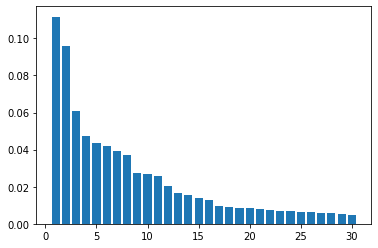

In [103]:
# plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.bar(range(1,31), pca.explained_variance_ratio_[1:31])

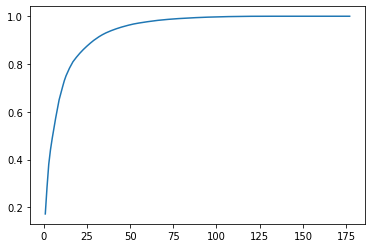

In [104]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

# Making the scree plot
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [130]:
pd.DataFrame(var_cumu).head(50)

,0
0,0.173004
1,0.284698
2,0.380769
3,0.441454
4,0.488920
5,0.532378
6,0.574091
7,0.613563
8,0.650510
9,0.678008


### <font color='green'>
<b>PCA Inference:</b> <br>
- 93% of the variance is explained by the first 35 Principal Components <br>
- We can try running models with 35 components and check how they perform
</font>

## Create PCA datasets

In [132]:
num_pcs = 35

In [133]:
# Get the top selected principal components 
pcs = IncrementalPCA(n_components=num_pcs)

In [134]:
# Utility method to create the new principal component datasets on the train & test data
def create_pca_data(train,test):
    train_pca = pd.DataFrame(pcs.fit_transform(train)).add_prefix('PC')
    # Index is lost after PCA as it works on Numpy arrays. 
    # Ref: https://github.com/scikit-learn/scikit-learn/issues/8238
    train_pca.index = train.index
    print(f'Train PCA data shape:{train_pca.shape}')
    display(train_pca.head(3))

    test_pca = pd.DataFrame(pcs.transform(test)).add_prefix('PC')
    test_pca.index = test.index
    print(f'Test PCA data shape:{test_pca.shape}')
    display(test_pca.head(3))
    
    
    
    return train_pca, test_pca
    

In [135]:
# Create PCA dataset for the original dataset
X_train_pca, X_test_pca = create_pca_data(X_train,X_test)

Train PCA data shape:(20589, 35)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
39295,0.160981,0.205599,0.279571,-0.006154,-0.125384,-0.213101,0.060869,-0.006099,-0.096308,0.009246,...,0.009057,-0.032074,-0.000699,-0.018005,0.009473,0.064752,-0.060727,-0.056980,0.010995,0.052147
69317,0.255659,0.222440,0.114780,-0.300156,-0.419896,-0.221869,0.129741,-0.125945,-0.316615,0.064546,...,-0.064787,0.096002,-0.014464,-0.069571,-0.020607,0.097593,-0.089414,-0.074299,0.089052,-0.037008
56470,-0.213336,-0.006388,-0.133460,-0.095326,-0.065611,-0.147891,0.023510,0.073383,0.025228,-0.062098,...,0.081642,0.015495,0.002535,-0.023048,0.022781,0.131545,-0.014890,-0.054689,0.051570,-0.007455


Test PCA data shape:(8825, 35)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
56927,0.297799,0.113752,-0.328313,0.110905,0.088386,-0.159804,-0.012203,0.187353,0.476320,-0.212589,...,0.184861,-0.047735,-0.056425,0.077679,0.026278,0.083733,-0.054035,-0.068633,-0.003324,-0.022093
74526,0.009838,0.263789,0.111029,-0.947923,-0.346082,0.499292,-0.121675,0.817844,0.765161,0.447287,...,-0.243172,0.304981,0.787970,-0.044909,0.071907,0.035939,0.055014,0.076842,0.179052,0.143316
71264,0.709712,0.315282,-0.131051,0.007517,-0.043080,-0.175332,0.082336,-0.151477,0.036341,0.033509,...,-0.010458,0.043241,0.001922,-0.077267,-0.017838,0.016849,-0.017854,0.010419,0.041555,0.038732


In [136]:
# Create PCA dataset for the oversampled dataset
X_oversampled_train_pca, X_oversampled_test_pca = create_pca_data(X_oversampled_train,X_oversampled_test)

Train PCA data shape:(37927, 35)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
8832,1.159951,0.261434,-1.065757,-0.601512,-0.073703,0.109619,-0.288380,-0.060268,-0.226695,-0.084569,...,0.089939,-0.112147,-0.032950,0.047296,-0.033867,0.009837,-0.065953,0.097898,0.017845,-0.032925
29160,0.141077,-0.575069,0.202473,0.166856,-0.039944,0.343416,-0.061048,0.316656,-0.395349,-0.032605,...,-0.058368,0.046564,0.065685,-0.008249,0.059489,-0.007159,0.003439,-0.089760,0.003095,0.002754
33763,-0.383527,0.149169,0.071192,-0.073267,-0.353133,-0.019566,0.035929,-0.282779,0.017303,0.005259,...,-0.044497,-0.019082,-0.042274,0.066788,-0.177019,0.005637,0.007566,-0.091175,-0.161776,-0.040067


Test PCA data shape:(16255, 35)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
28616,0.002799,0.417162,-0.060976,0.375860,0.459414,0.086396,0.028588,-0.018705,-0.032857,0.060610,...,0.008240,0.042267,-0.001432,0.018704,-0.069106,0.026748,0.011128,-0.033925,-0.107056,-0.003491
40056,-0.336162,-0.029744,-0.532015,-0.054308,-0.413408,-0.027528,-0.752000,-0.333859,-0.146677,-0.079275,...,0.025168,-0.038736,0.000703,0.012463,-0.009293,-0.063051,-0.021509,-0.031534,-0.018740,0.001183
37037,0.665755,-0.203257,0.201337,-0.263918,-0.007244,0.608645,-0.005390,0.227185,0.045546,0.060231,...,-0.000125,-0.069365,0.038511,-0.015644,-0.034489,0.045206,-0.012085,-0.021227,-0.043191,0.024540


In [137]:
# Create PCA dataset for the SMOTE dataset
X_smote_train_pca, X_smote_test_pca = create_pca_data(X_smote_train,X_smote_test)

Train PCA data shape:(37927, 35)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
8832,1.165863,0.300971,-1.084403,-0.620355,-0.046025,0.044758,-0.023874,-0.245868,-0.217241,-0.167060,...,-0.165312,-0.053633,-0.068527,-0.043100,0.022791,-0.019215,0.042569,-0.071570,0.023228,-0.019544
29160,0.146138,-0.580140,0.163845,0.170876,-0.177032,0.286153,0.262434,0.053606,-0.419275,-0.152175,...,0.066542,0.032894,-0.009912,0.007954,-0.004890,0.032961,-0.027170,0.034227,0.032052,0.025532
33763,-0.405178,0.067189,0.090025,-0.094926,-0.283038,-0.145902,-0.231246,-0.033572,-0.059956,-0.094602,...,0.030064,-0.071670,-0.005783,-0.109977,-0.036519,-0.018409,0.008798,0.011779,0.035874,-0.005993


Test PCA data shape:(16255, 35)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
28616,0.018642,0.44287,-0.041185,0.432753,0.338474,0.203796,-0.017874,0.016656,-0.051156,0.036360,...,-0.005145,0.009282,-0.018031,0.035378,-0.000024,0.002080,0.034573,0.003122,-0.130989,0.004800
40056,0.071775,-0.56590,0.194870,0.151914,-0.236192,0.110528,0.203004,0.017889,-0.139983,-0.130324,...,-0.020625,0.043620,-0.027578,0.026008,0.021778,0.050029,-0.005407,-0.036160,0.002680,0.116064
37037,-0.076668,0.28050,-0.019440,0.264442,0.280596,0.104148,-0.069162,-0.012656,0.167114,0.109655,...,0.042516,-0.030530,0.010712,-0.031041,0.006379,0.010180,-0.010701,0.030458,0.025897,0.091418


## Check for multicollinearity - PCA

Verify that the features (Principal Components) created from PCA are not correlated to each other

In [138]:
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat.shape

(35, 35)

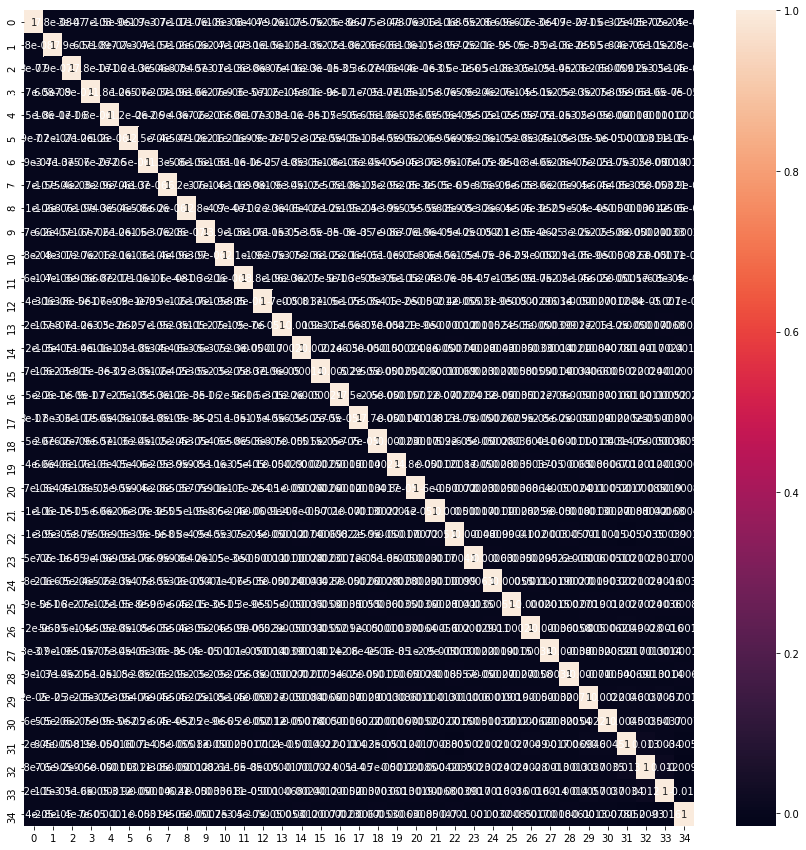

In [139]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=False)

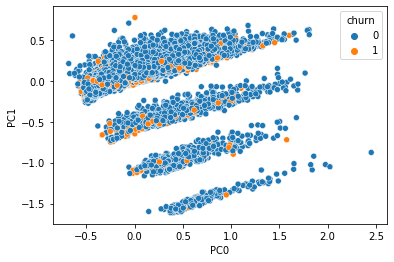

In [140]:
# Plotting the data of PC0 vs PC1
df_final = pd.concat([X_train_pca, y_train], axis=1)
sns.scatterplot(data=df_final, x="PC0", y="PC1",hue="churn")


## Model building - PCA

In [141]:
model_result_pca = pd.DataFrame()

### Default Model Building

In [142]:
# Default model run
run_all_models(X_train_pca, X_test_pca, y_train, y_test,'PCA',model_result_pca)
model_result_pca
#model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.223 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.647 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 9.786 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.044 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 19.676 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 4.637 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 3.89 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 39.904 sec


,PCA-LR,PCA-DCART,PCA-RF,PCA-NB,PCA-GB,PCA-XGB,PCA-ABC
Accuracy,92.839,89.224,92.816,88.907,93.076,93.212,92.657
Null Accuracy,91.977,91.977,91.977,91.977,91.977,91.977,91.977
AUROC,61.427,64.941,59.480,66.638,62.910,62.146,62.037
Sensitivity,24.011,36.017,19.774,40.113,26.977,25.141,25.565
Specificity,98.842,93.865,99.187,93.162,98.842,99.150,98.509
Precision,64.394,33.865,67.961,33.850,67.018,72.065,59.934
F1 Score,34.979,34.908,30.635,36.716,38.469,37.277,35.842
Negative Predictive Value,93.716,94.388,93.410,94.691,93.946,93.821,93.817
False Positive Rate,1.158,6.135,0.813,6.838,1.158,0.850,1.491
False Negative Rate,75.989,63.983,80.226,59.887,73.023,74.859,74.435


In [143]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA-GB,93.076,91.977,62.910,26.977,98.842,67.018,38.469,93.946,1.158,73.023,32.982
PCA-XGB,93.212,91.977,62.146,25.141,99.150,72.065,37.277,93.821,0.850,74.859,27.935
PCA-NB,88.907,91.977,66.638,40.113,93.162,33.850,36.716,94.691,6.838,59.887,66.150
PCA-ABC,92.657,91.977,62.037,25.565,98.509,59.934,35.842,93.817,1.491,74.435,40.066
PCA-LR,92.839,91.977,61.427,24.011,98.842,64.394,34.979,93.716,1.158,75.989,35.606
PCA-DCART,89.224,91.977,64.941,36.017,93.865,33.865,34.908,94.388,6.135,63.983,66.135
PCA-RF,92.816,91.977,59.480,19.774,99.187,67.961,30.635,93.410,0.813,80.226,32.039


### Model building with HPT

In [144]:
model_type_pca_hpt = 'PCA-HPT'

#### HPT for Random Forest

In [145]:
# %%time
grid_search_rf.fit(X_train_pca,y_train)
rf_grid_best_est = grid_search_rf.best_estimator_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


In [146]:
# %%time
# random_search_rf.fit(X_train_pca,y_train)
# rf_best_est = random_search_rf.best_estimator_

In [147]:
model_result_pca[f'{model_type_pca_hpt}-RF'] = model_fit_predict(rf_grid_best_est,X_train_pca, X_test_pca, y_train, y_test)

#### HPT for XGBoost

In [148]:
%%time
random_search_xgb.fit(X_train_pca,y_train)
xgb_best_est = random_search_xgb.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 31.4 s, sys: 1.02 s, total: 32.4 s
Wall time: 2h 42min 40s


In [149]:
model_result_pca[f'{model_type_pca_hpt}-XGB'] = model_fit_predict(xgb_best_est,X_train_pca, X_test_pca, y_train, y_test)

### Model on oversampled data

In [150]:
run_all_models(X_oversampled_train_pca, X_oversampled_test_pca, y_oversampled_train, y_oversampled_test,'PCA - Oversampled',model_result_pca)
model_result_pca.T


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.263 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.243 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 39.232 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.092 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 28.413 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 8.212 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 5.841 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 1.0 min 82.305 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA-LR,92.839,91.977,61.427,24.011,98.842,64.394,34.979,93.716,1.158,75.989,35.606
PCA-DCART,89.224,91.977,64.941,36.017,93.865,33.865,34.908,94.388,6.135,63.983,66.135
PCA-RF,92.816,91.977,59.480,19.774,99.187,67.961,30.635,93.410,0.813,80.226,32.039
PCA-NB,88.907,91.977,66.638,40.113,93.162,33.850,36.716,94.691,6.838,59.887,66.150
PCA-GB,93.076,91.977,62.910,26.977,98.842,67.018,38.469,93.946,1.158,73.023,32.982
PCA-XGB,93.212,91.977,62.146,25.141,99.150,72.065,37.277,93.821,0.850,74.859,27.935
PCA-ABC,92.657,91.977,62.037,25.565,98.509,59.934,35.842,93.817,1.491,74.435,40.066
PCA-HPT-RF,92.839,91.977,58.848,18.362,99.335,70.652,29.148,93.311,0.665,81.638,29.348
PCA-HPT-XGB,93.156,91.977,66.176,34.040,98.312,63.757,44.383,94.471,1.688,65.960,36.243
PCA - Oversampled-LR,82.467,50.132,82.468,82.976,81.961,82.064,82.517,82.876,18.039,17.024,17.936


### Model on SMOTE data

In [151]:
run_all_models(X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test,'PCA - SMOTE',model_result_pca)
model_result_pca.T


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.26 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 2.004 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 17.142 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.058 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 36.062 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 36.446 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 7.354 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 1.0 min 98.346 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA-LR,92.839,91.977,61.427,24.011,98.842,64.394,34.979,93.716,1.158,75.989,35.606
PCA-DCART,89.224,91.977,64.941,36.017,93.865,33.865,34.908,94.388,6.135,63.983,66.135
PCA-RF,92.816,91.977,59.480,19.774,99.187,67.961,30.635,93.410,0.813,80.226,32.039
PCA-NB,88.907,91.977,66.638,40.113,93.162,33.850,36.716,94.691,6.838,59.887,66.150
PCA-GB,93.076,91.977,62.910,26.977,98.842,67.018,38.469,93.946,1.158,73.023,32.982
PCA-XGB,93.212,91.977,62.146,25.141,99.150,72.065,37.277,93.821,0.850,74.859,27.935
PCA-ABC,92.657,91.977,62.037,25.565,98.509,59.934,35.842,93.817,1.491,74.435,40.066
PCA-HPT-RF,92.839,91.977,58.848,18.362,99.335,70.652,29.148,93.311,0.665,81.638,29.348
PCA-HPT-XGB,93.156,91.977,66.176,34.040,98.312,63.757,44.383,94.471,1.688,65.960,36.243
PCA - Oversampled-LR,82.467,50.132,82.468,82.976,81.961,82.064,82.517,82.876,18.039,17.024,17.936


### Model on (SMOTE + HPT)

In [152]:
model_type_pca_smotehpt = 'PCA-SMOTE+HPT'

#### SMOTE+HPT for Random Forest

In [1]:
%%time
grid_search_rf.fit(X_smote_train_pca,y_smote_train)
rf_grid_smote_best_est = grid_search_rf.best_estimator_

NameError: name 'grid_search_rf' is not defined

In [2]:
# %%time

# random_search_rf.fit(X_smote_train_pca,y_smote_train)
# rf_smote_best_est = random_search_rf.best_estimator_


In [3]:
model_result_pca[f'{model_type_pca_smotehpt}-RF'] = model_fit_predict(rf_grid_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

NameError: name 'model_fit_predict' is not defined

####  SMOTE+HPT for XGBoost

In [ ]:
model_result_pca.T

In [ ]:
%%time
random_search_xgb.fit(X_smote_train_pca,y_smote_train)
xgb_smote_best_est = random_search_xgb.best_estimator_

In [ ]:
model_result_pca[f'{model_type_pca_smotehpt}-XGB'] = model_fit_predict(xgb_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

# Model building 2 - without PCA

In [120]:
X_train.shape

(20589, 177)

## Apply RFE to reduce the number of features

### Apply RFE and get the top n columns

In [122]:
# Based on the PCA results, we notice that random forest performs well on this data
# Get the top 50 features based on RandomForest Classifier
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=50)
rfe = rfe.fit(X_train, y_train)

In [123]:
rfe_df = pd.DataFrame(zip(X_train.columns,rfe.support_,rfe.ranking_),columns = ['Feature','Selected','Ranking'])
rfe_df.sort_values(by=['Ranking'])

,Feature,Selected,Ranking
0,arpu_6,True,1
95,total_rech_amt_8,True,1
94,total_rech_amt_7,True,1
93,total_rech_amt_6,True,1
91,total_rech_num_7,True,1
90,total_rech_num_6,True,1
175,last_day_rch_amt_gphase_avg,True,1
80,total_ic_mou_8,True,1
79,total_ic_mou_7,True,1
78,total_ic_mou_6,True,1


In [124]:
rfe_cols = X_train.columns[rfe.support_]
rfe_cols

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_mou_7',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_8', 'aon',
       'last_rech_num_days', 'arpu_gphase_avg', 'arpu_aphase_avg',
       'arpu_gaphase_diff', 'total_og_mou_gphase_avg',
       'total_og_mou_gaphase_diff', 'total_ic_mou_gphase_avg',
       'total_ic_mou_gaphase_diff', 'vol_aphase_avg', 'roam_mou_aphase_avg',
       'roam_mou_gaphase_diff', 'total_rech_data_amt_8',
       'total_rech_amt_gphase_avg', 'total_rech_amt_aphase_avg',
       'total_rech_amt_gaphase_diff', 'total_rech_num_gphase_avg

### Create the datasets for RFE columns

In [125]:
X_train_rfe = X_train[rfe_cols]
X_test_rfe = X_test[rfe_cols]

X_oversampled_train_rfe = X_oversampled_train[rfe_cols]
X_oversampled_test_rfe = X_oversampled_test[rfe_cols]

X_smote_train_rfe = X_smote_train[rfe_cols]
X_smote_test_rfe = X_smote_test[rfe_cols]

## Build  Models

In [126]:
model_result_featimp = pd.DataFrame()

### Default model building

In [127]:
# Default model run - Feature Importance (FI)
run_all_models(X_train_rfe, X_test_rfe, y_train, y_test,'FI', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.322 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.232 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 8.908 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.043 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 19.316 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 5.696 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 3.712 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 39.23 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI-GB,94.652,91.977,75.498,52.684,98.312,73.137,61.248,95.971,1.688,47.316,26.863
FI-XGB,94.629,91.977,74.648,50.847,98.448,74.074,60.302,95.827,1.552,49.153,25.926
FI-ABC,94.470,91.977,75.077,51.977,98.177,71.318,60.131,95.908,1.823,48.023,28.682
FI-RF,94.504,91.977,72.195,45.621,98.768,76.359,57.118,95.418,1.232,54.379,23.641
FI-DCART,92.000,91.977,72.058,48.305,95.811,50.147,49.209,95.505,4.189,51.695,49.853
FI-LR,93.042,91.977,61.666,24.294,99.039,68.800,35.908,93.749,0.961,75.706,31.200
FI-NB,75.127,91.977,78.873,83.333,74.412,22.122,34.963,98.084,25.588,16.667,77.878


### Model with HPT

In [128]:
model_type_FI_hpt = 'FI-HPT'

#### HPT for Random Forest

In [129]:
%%time
grid_search_rf.fit(X_train_rfe,y_train)
rf_fi_grid_best_est = grid_search_rf.best_estimator_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
CPU times: user 43 s, sys: 769 ms, total: 43.8 s
Wall time: 16min 30s


In [130]:
# %%time
# random_search_rf.fit(X_train_rfe,y_train)
# rf_fi_best_est = random_search_rf.best_estimator_

In [131]:
model_result_featimp[f'{model_type_FI_hpt}-RF'] = model_fit_predict(rf_fi_grid_best_est,X_train_rfe, X_test_rfe, y_train, y_test)

#### HPT for XGBoost

In [132]:
%%time
random_search_xgb.fit(X_train_rfe,y_train)
xgb_fi_best_est = random_search_xgb.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 31.2 s, sys: 271 ms, total: 31.5 s
Wall time: 24min 33s


In [133]:
model_result_featimp[f'{model_type_FI_hpt}-XGB'] = model_fit_predict(xgb_fi_best_est,X_train_rfe, X_test_rfe, y_train, y_test)

### Model with Oversampled Data

In [134]:
run_all_models(X_oversampled_train_rfe, X_oversampled_test_rfe, y_oversampled_train, y_oversampled_test,'FI - Oversampled', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.453 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.285 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 11.943 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.068 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 27.724 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 10.145 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 5.659 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 57.278 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI - Oversampled-RF,98.690,50.132,98.693,100.000,97.386,97.440,98.703,100.000,2.614,0.000,2.560
FI - Oversampled-DCART,97.318,50.132,97.325,100.000,94.650,94.896,97.381,100.000,5.350,0.000,5.104
FI - Oversampled-GB,89.659,50.132,89.659,89.933,89.385,89.393,89.662,89.926,10.615,10.067,10.607
FI - Oversampled-XGB,89.505,50.132,89.505,89.674,89.336,89.322,89.498,89.688,10.664,10.326,10.678
FI - Oversampled-ABC,87.007,50.132,87.002,85.245,88.759,88.295,86.744,85.811,11.241,14.755,11.705
FI - Oversampled-LR,83.550,50.132,83.550,83.568,83.532,83.465,83.516,83.634,16.468,16.432,16.535
FI - Oversampled-NB,77.238,50.132,77.263,86.911,67.616,72.749,79.202,83.853,32.384,13.089,27.251
FI-GB,94.652,91.977,75.498,52.684,98.312,73.137,61.248,95.971,1.688,47.316,26.863
FI-HPT-XGB,94.572,91.977,74.939,51.554,98.325,72.854,60.380,95.879,1.675,48.446,27.146
FI-XGB,94.629,91.977,74.648,50.847,98.448,74.074,60.302,95.827,1.552,49.153,25.926


### Model with SMOTE Data

In [135]:
run_all_models(X_smote_train_rfe, X_smote_test_rfe, y_smote_train, y_smote_test,'FI - SMOTE', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.512 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 2.259 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 17.988 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.07 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 37.059 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 11.311 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 7.534 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 1.0 min 75.735 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI - Oversampled-RF,98.690,50.132,98.693,100.000,97.386,97.440,98.703,100.000,2.614,0.000,2.560
FI - Oversampled-DCART,97.318,50.132,97.325,100.000,94.650,94.896,97.381,100.000,5.350,0.000,5.104
FI - SMOTE-RF,95.872,50.132,95.875,96.978,94.772,94.859,95.907,96.925,5.228,3.022,5.141
FI - SMOTE-XGB,91.824,50.132,91.825,92.253,91.398,91.429,91.839,92.224,8.602,7.747,8.571
FI - SMOTE-GB,91.683,50.132,91.683,91.969,91.398,91.405,91.686,91.962,8.602,8.031,8.595
FI - SMOTE-DCART,91.227,50.132,91.232,93.042,89.422,89.743,91.363,92.816,10.578,6.958,10.257
FI - Oversampled-GB,89.659,50.132,89.659,89.933,89.385,89.393,89.662,89.926,10.615,10.067,10.607
FI - Oversampled-XGB,89.505,50.132,89.505,89.674,89.336,89.322,89.498,89.688,10.664,10.326,10.678
FI - SMOTE-ABC,89.622,50.132,89.619,88.638,90.600,90.366,89.494,88.909,9.400,11.362,9.634
FI - Oversampled-ABC,87.007,50.132,87.002,85.245,88.759,88.295,86.744,85.811,11.241,14.755,11.705


### Model with SMOTE+HPT

In [136]:
model_type_FI_smotehpt = 'FI-SMOTE+HPT'

#### HPT for Random Forest

In [ ]:
%%time
grid_search_rf.fit(X_smote_train_rfe,y_smote_train)
rf_grid_fi_smote_best_est = grid_search_rf.best_estimator_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


In [ ]:
# %%time

# random_search_rf.fit(X_smote_train,y_smote_train)
# rf_fi_smote_best_est = random_search_rf.best_estimator_


In [ ]:
model_result_featimp[f'{model_type_FI_smotehpt}-RF'] = model_fit_predict(rf_grid_fi_smote_best_est,X_smote_train_rfe, X_smote_test_rfe, y_smote_train, y_smote_test)

#### HPT for XGBoost

In [ ]:
%%time
random_search_xgb.fit(X_smote_train_rfe,y_smote_train)
xgb_fi_smote_best_est = random_search_xgb.best_estimator_

In [ ]:
model_result_featimp[f'{model_type_FI_smotehpt}-XGB'] = model_fit_predict(xgb_fi_smote_best_est,X_smote_train_rfe, X_smote_test_rfe, y_smote_train, y_smote_test)

### Summary from all the Models

Goal: Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

In [ ]:

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

<font color = 'green'>
<b>Insights from the summary table</b><br>
    
- Results are similar to the PCA models. Oversampled data performs the best, followed by SMOTE data and then the original dataset with the class imbalance.<br>
- Feature importance from the hyperparameter tuned Random Forest & XGB is given below.  <br>
- Feature importance of the oversampled RF model (best model from the summary table) is also identified.<br>
</font>

## Best Model for Feature Importance

### Feature Importance with Random Forest & XGB models

In [ ]:
print(f'Feature Importance from Random Forest HPT model')

imp_rf_df = pd.DataFrame({
    "Varname": X_train_rfe.columns,
    "Imp": rf_grid_fi_best_est.feature_importances_
})
imp_rf_df.sort_values(by="Imp", ascending=False)

In [ ]:
print(f'Feature Importance from XGB HPT model')

imp_xgb_df = pd.DataFrame({
    "Varname": X_train_rfe.columns,
    "Imp": xgb_fi_best_est.feature_importances_
})
imp_xgb_df.sort_values(by="Imp", ascending=False)

In [ ]:
print(f'Feature Importance from RF - oversampled model')
model_rf_oversampled = RandomForestClassifier(random_state=42).fit(X_oversampled_train_rfe, y_oversampled_train_rfe)

imp_rf_oversampled_df = pd.DataFrame({
    "Varname": X_oversampled_train_rfe.columns,
    "Imp": model_rf_oversampled.feature_importances_
})
imp_rf_oversampled_df.sort_values(by="Imp", ascending=False)

# Final Insights

## Best Model - with PCA

### Best Model - PCA: Goal & Approach


<font color='green'>
    

<b>Goal:</b>

-  Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.   
<br>

<b>Approach:</b> <br>
       
- Models were created with 3 different types of data: <br>
    1. Input Data<br>
    2. Oversampled Data<br>
    3. SMOTE Data<br>
  <br>
  
- Hyperparameter tuning was done on Random Forest and XGBoost Models  
  <br>
- PCA was applied on each of the datasets before feeding it to the models.   
  From PCA, it was noticed that with 35 features we can explain 93% of the variance.  
  Hence first 35 principal components were considered to build the models.  
  <br>
- Different metrics associated with a classification model were computed for each of the model  
  <br>
  
- In this case since the goal is to ensure that we don't miss any churners, we should reduce on the false negatives (misclassifying churners as non-churners.
<br>

- Since we need to reduce on the false negatives, metrics like sensitivity, false negative rate, F1-score are good metrics to consider.
<br>

- Below is the model summary from all models along with the evaluation metrics for each of them. 

</font>

### Best Model - PCA: Summary from all models

In [ ]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

### Best Model - PCA: Conclusion

<font color = 'green'>
<b> Insights from the models summary table - PCA </b> <br>
    
- Evaluation Metrics - **Sensitivity & Specificity** <br>    
- Models which address the **class imbalance perform better** than the models without any class imbalance treatement <br> 
- Models run on **oversampled data perform better** than models run on **SMOTE data**<br>
- **Random Forest algorithm** performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the **hyperparameter tuned model with XGB** outperforms the other models.<br>
- Results from most of the models are comparable except for the **Naive Bayes model which performs poorly** on this dataset<br>
<br>

<b>Best Model - PCA</b><br>
- **PCA model with 35 principal components run on oversampled data with Random Forest performs best on this dataset**
</font>

## Important features

### Important Features: Goal & Approach


<font color='green'>
    

<b>Goal:</b>

-  Identify important variables that are strong predictors of churn   
<br>

<b>Approach:</b> <br>
       
- Similar to PCA, models were created with 3 different types of data. Hyperparameter tuning was done. Evaluation metrics were computed for each of the models.  
  <br>
- Based on the evaluation metrics, the best model  was identified.  
<br>
- Feature importance was determined on this best model  
<br> 

</font>

### Importat Features: Summary from best model

In [ ]:

imp_rf_oversampled_df.sort_values(by="Imp", ascending=False)

### Important Features: Conclusion

<font color = 'green'>
<b> Important Features </b> <br>
    
Based on the results, we can conclude that the top 10 important features are as below (given in the order of importance)<br>    
 
</font>

## Correlation matrix with the target for the top 10 important features

In [ ]:
imp_features = ['total_rech_amt_gaphase_avg','fb_user_8','total_mou_gaphase_avg','arpu_gaphase_avg','loc_ic_gaphase_avg','last_rech_num_days']

In [ ]:
df = cust[imp_features + ['churn']]
corr = df.corr() 

In [ ]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [ ]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

## Conclusion - recommendation to manage customer churn

Finally, recommend strategies to manage customer churn based on your observations.

<font color = 'green'>
<b> Recommendations to manage customer churn </b> <br>
    
- Identification of good phase vs action phase gives a good early indication on the customers like to churn <br>  
- For high value customers, based on the model results, the customers likely to churn needs to be addressed on priority
- NOTE: Model has to be retrained regularly to identify any patterns in the data


</font>

# Appendix

## Understanding the classification metrics

| Metric   | Details| 
|:----------|:---------------|
| Classification Accuracy % | Classification accuracy is the proportion of the total number of predictions that were correct.  | 
|Null Accuracy %  | Null accuracy is the baseline accuracy that can be achieved by always predicting the most frequent class  | 
| Specificity | Specificity or true negative rate measures the proportion of actual negatives that are correctly identified  | 
| Sensitivity (Recall) | Sensitivity, hit rate, recall, or true positive rate is the proportion of actual positives which are correctly identified as positives. It is a measure of completeness & quantity.  | 
| Precision  | Precision is the proportion of positive cases that were correctly identified. It is a measure of exactness or quality.  | 
| F1-Score |  F1-Score is the harmonic mean of precision and recall values. | 
| Log-Loss |  Log loss measures the uncertainity of the probabilities of the model by comparing them to the true labels. A perfect model would have a log loss of 0. |
| Negative Predictive Value | Negative predictive value is defined as the proportion of predicted negatives which are real negatives. It reflects the probability that a predicted negative is a true negative. |
|Fall Out  | Fall out or false positive rate is the proportion of the negative samples that were incorrectly classified.| 
|False Negative Rate | The false negative rate or the miss rate is the proportion of true positives that were incorrectly classified. |
|False Discovery Rate  | The FDR is defined as the proportion of false discoveries. It is the compliment of precision (1-Precision)  | 